# Multimodal RAG: Enhancing RAG outputs with image results

Traditionally, Retrieval-Augmented Generation (RAG) use cases focus on synthesizing information by retrieving textual context from private data sources. But much of our information ecosystem is visual. In this notebook, we show you how to incorporate visual information alongside synthesized textual insights!


Imagine this concept applied to a textbook or a user manual. A richly detailed image can convey nuances that text alone may struggle to express. Using the [Unstructured Platform](https://unstructured.io/developers), we can leverage frontier multimodal large language models (LLMs) to generate detailed image descriptions. These descriptions can then be seamlessly integrated into RAG workflows, enhancing the contextual depth and quality of the generated outputs. Then, when one of these image descriptions appears in a chunk that was retrieved as context for a RAG response, we can recreate the image, using the base64 encoding we stored in the chunk's metadata!


In this notebook, we'll explore how leveraging visual data in RAG can unlock new possibilities for enriched, context-aware responses. Let's dive into the intersection of visual and textual AI for a more dynamic approach to information synthesis!

# Dependencies

In [ ]:
!pip install -q load_dotenv load_dotenv faiss-cpu unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 26.7 MB/s eta 0:00:00
   ━

In [ ]:
import os
import faiss
import uuid
import json
from dotenv import load_dotenv
import faiss
import numpy as np
import re
import base64
from typing import List, Dict, Any
from openai import OpenAI
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from collections import OrderedDict

load_dotenv('/content/.env')

from unstructured.staging import base

Settings.llm = OpenAI(model="gpt-4o-mini", temperature=0.1)
Settings.embed_model = OpenAIEmbedding(model= 'text-embedding-3-large')

# Using the Unstructured Platform to load our data

For this example, we will use the widely read [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar to perform visually-enriched QnA. This blog post is famous for how well it *illustrates* the concepts behind the ubiquitous transformer architecture.

We have saved printer-friendly PDF of the webpage that we will use with the Unstructured Platform.

You can sign up for [Unstructured Platform](https://unstructured.io/developers) for a 14-day free trial to try this out yourself!

Start by creating a data source so Unstructured can access your documents. In our case, we want to load documents from an S3 bucket.



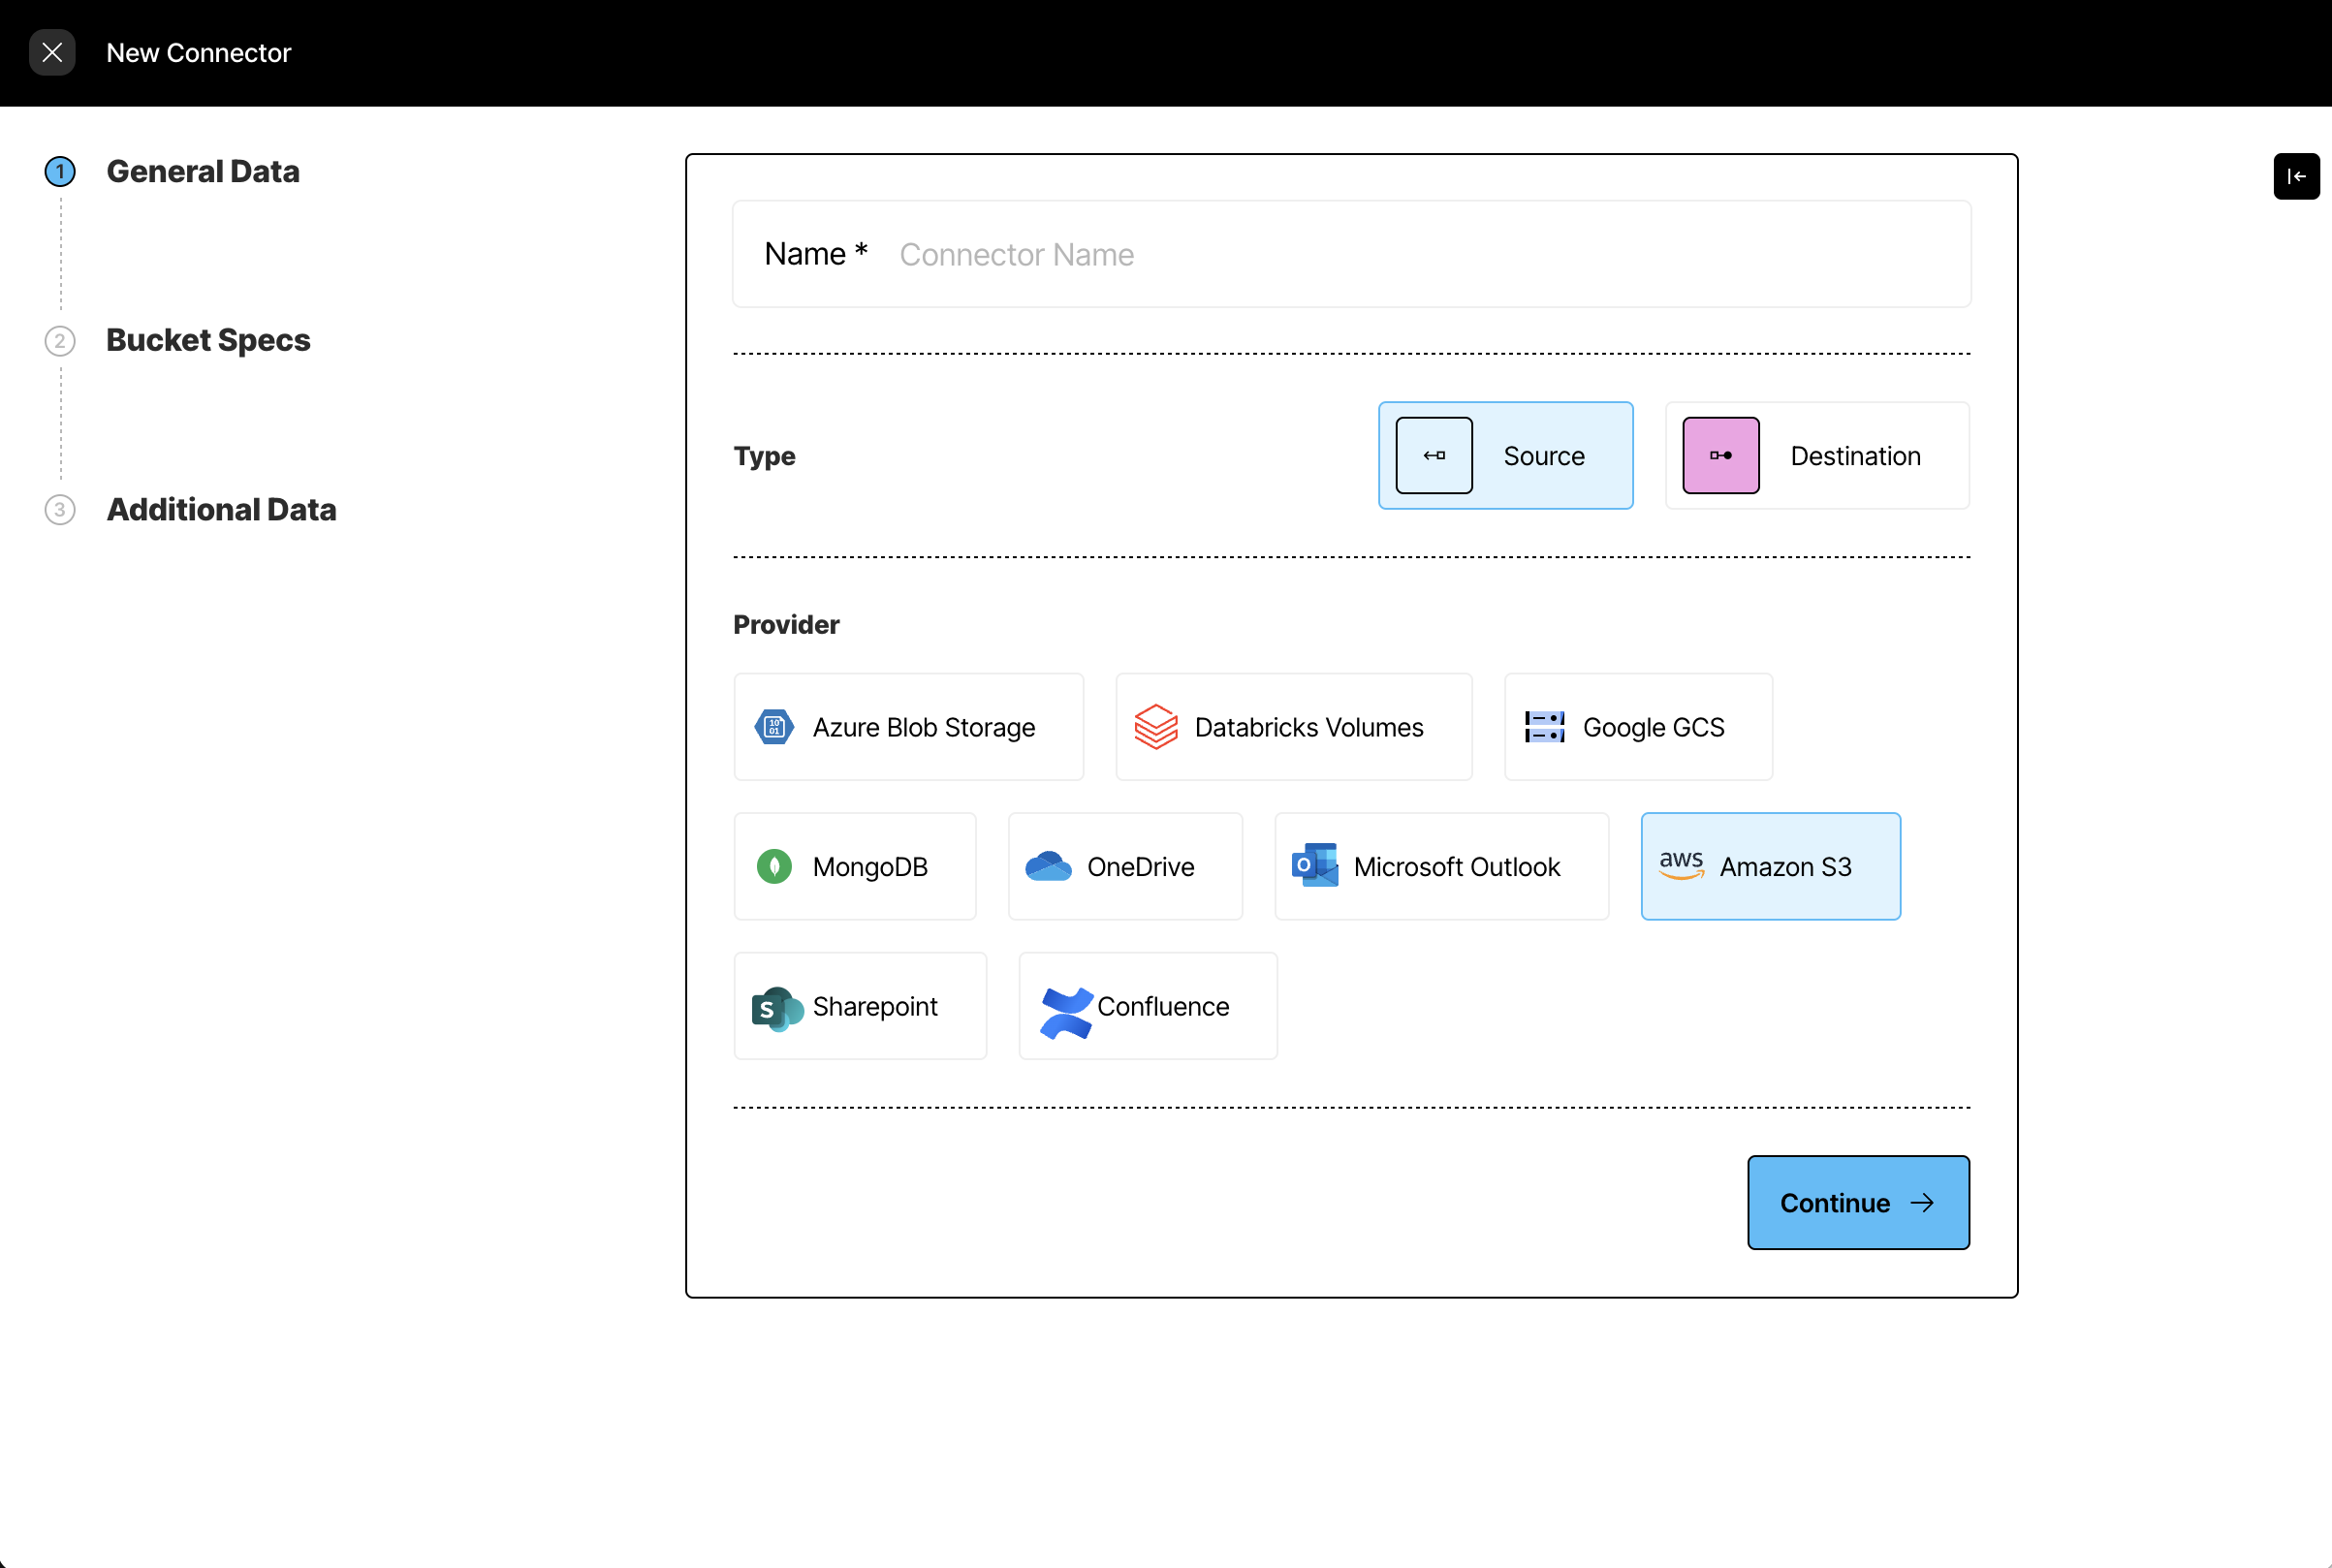

Enter the credentials to the S3 bucket

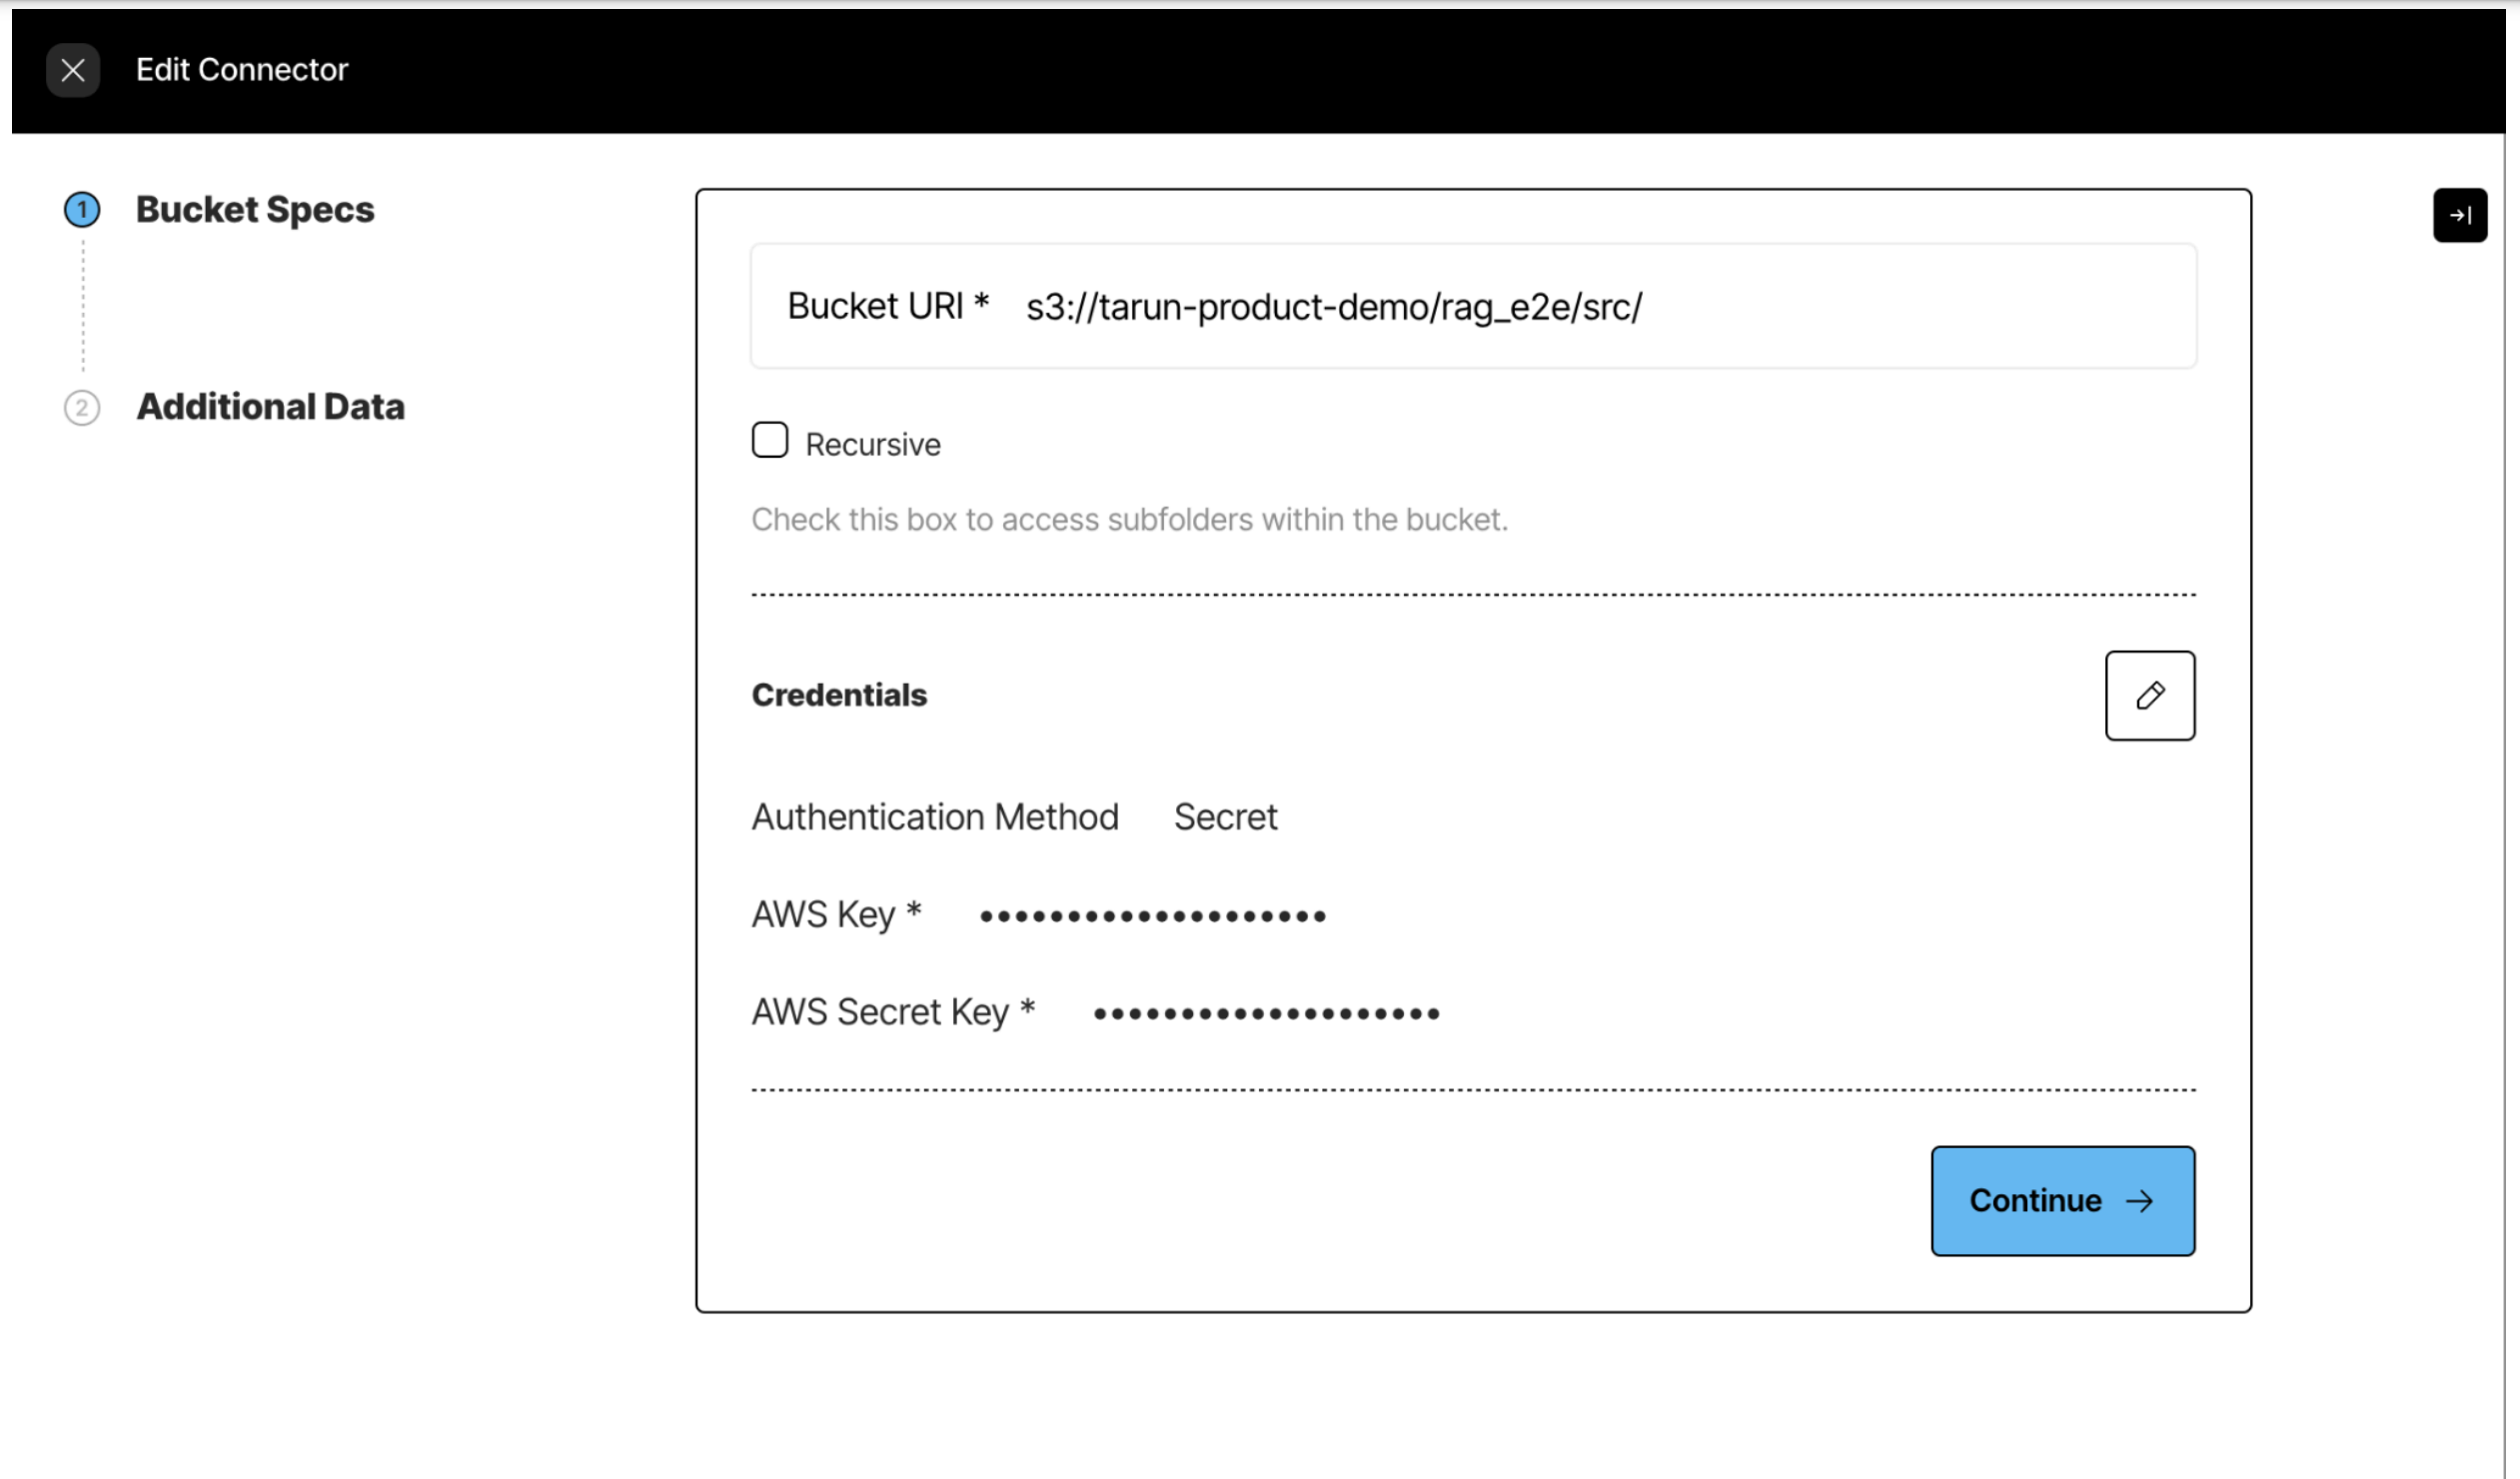


Next, connect Unstructured to your output location. For the sake of simplicity, we are going to store our outputs to S3 as well.

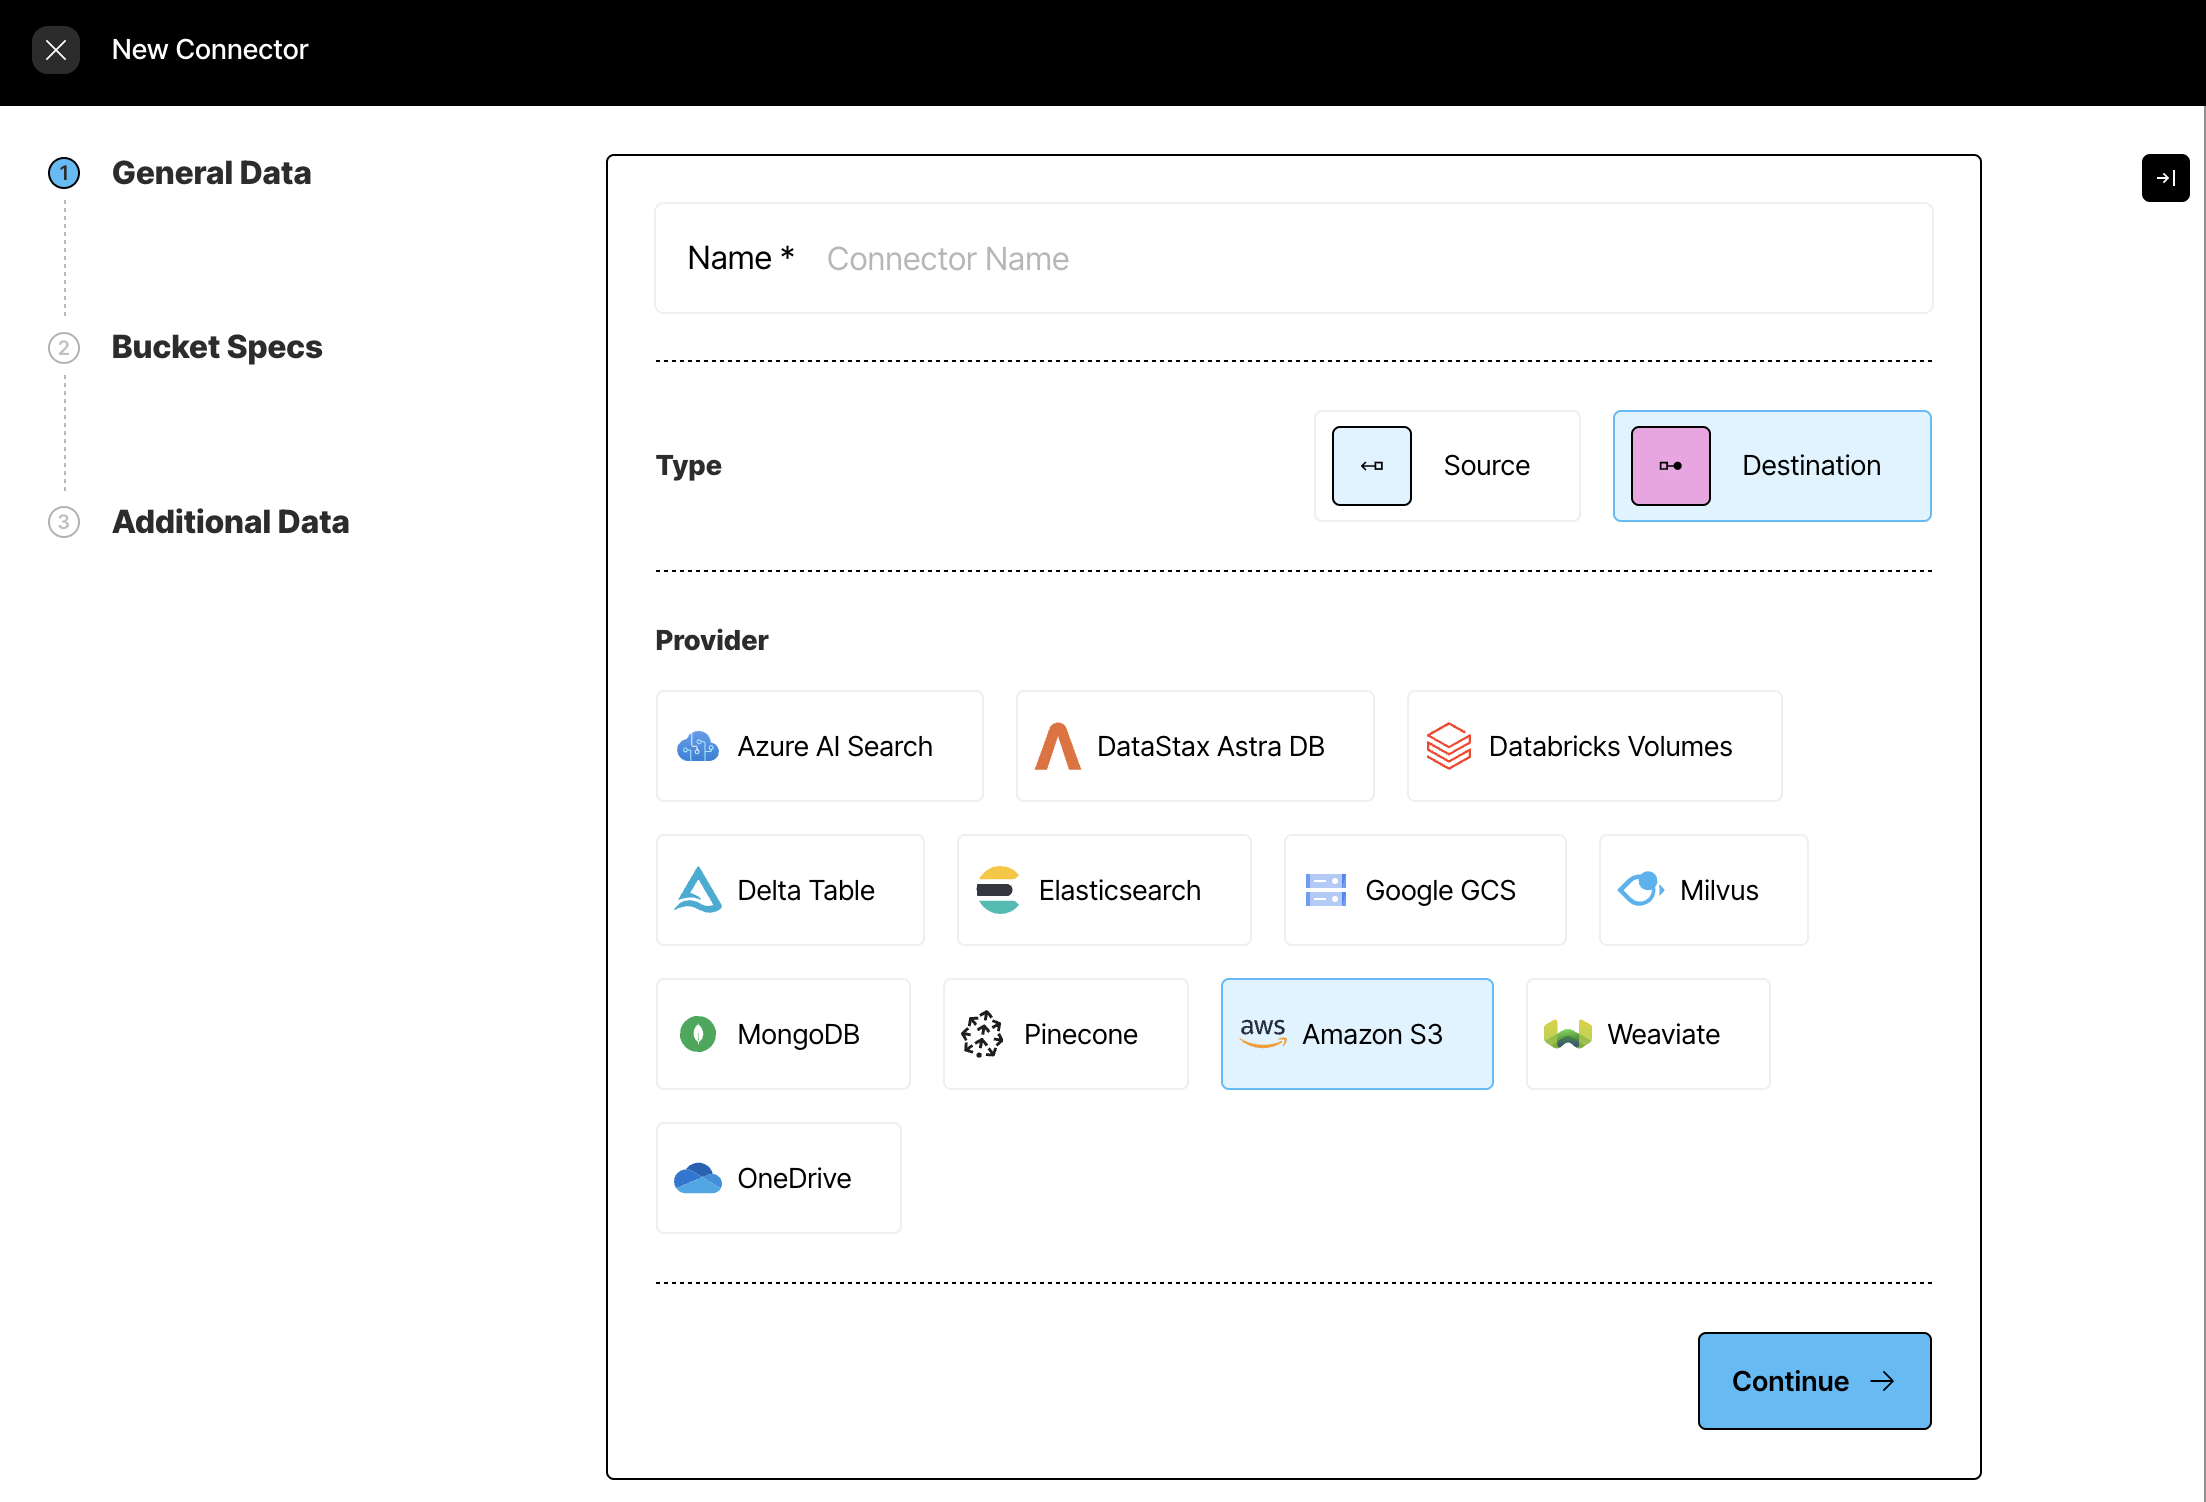

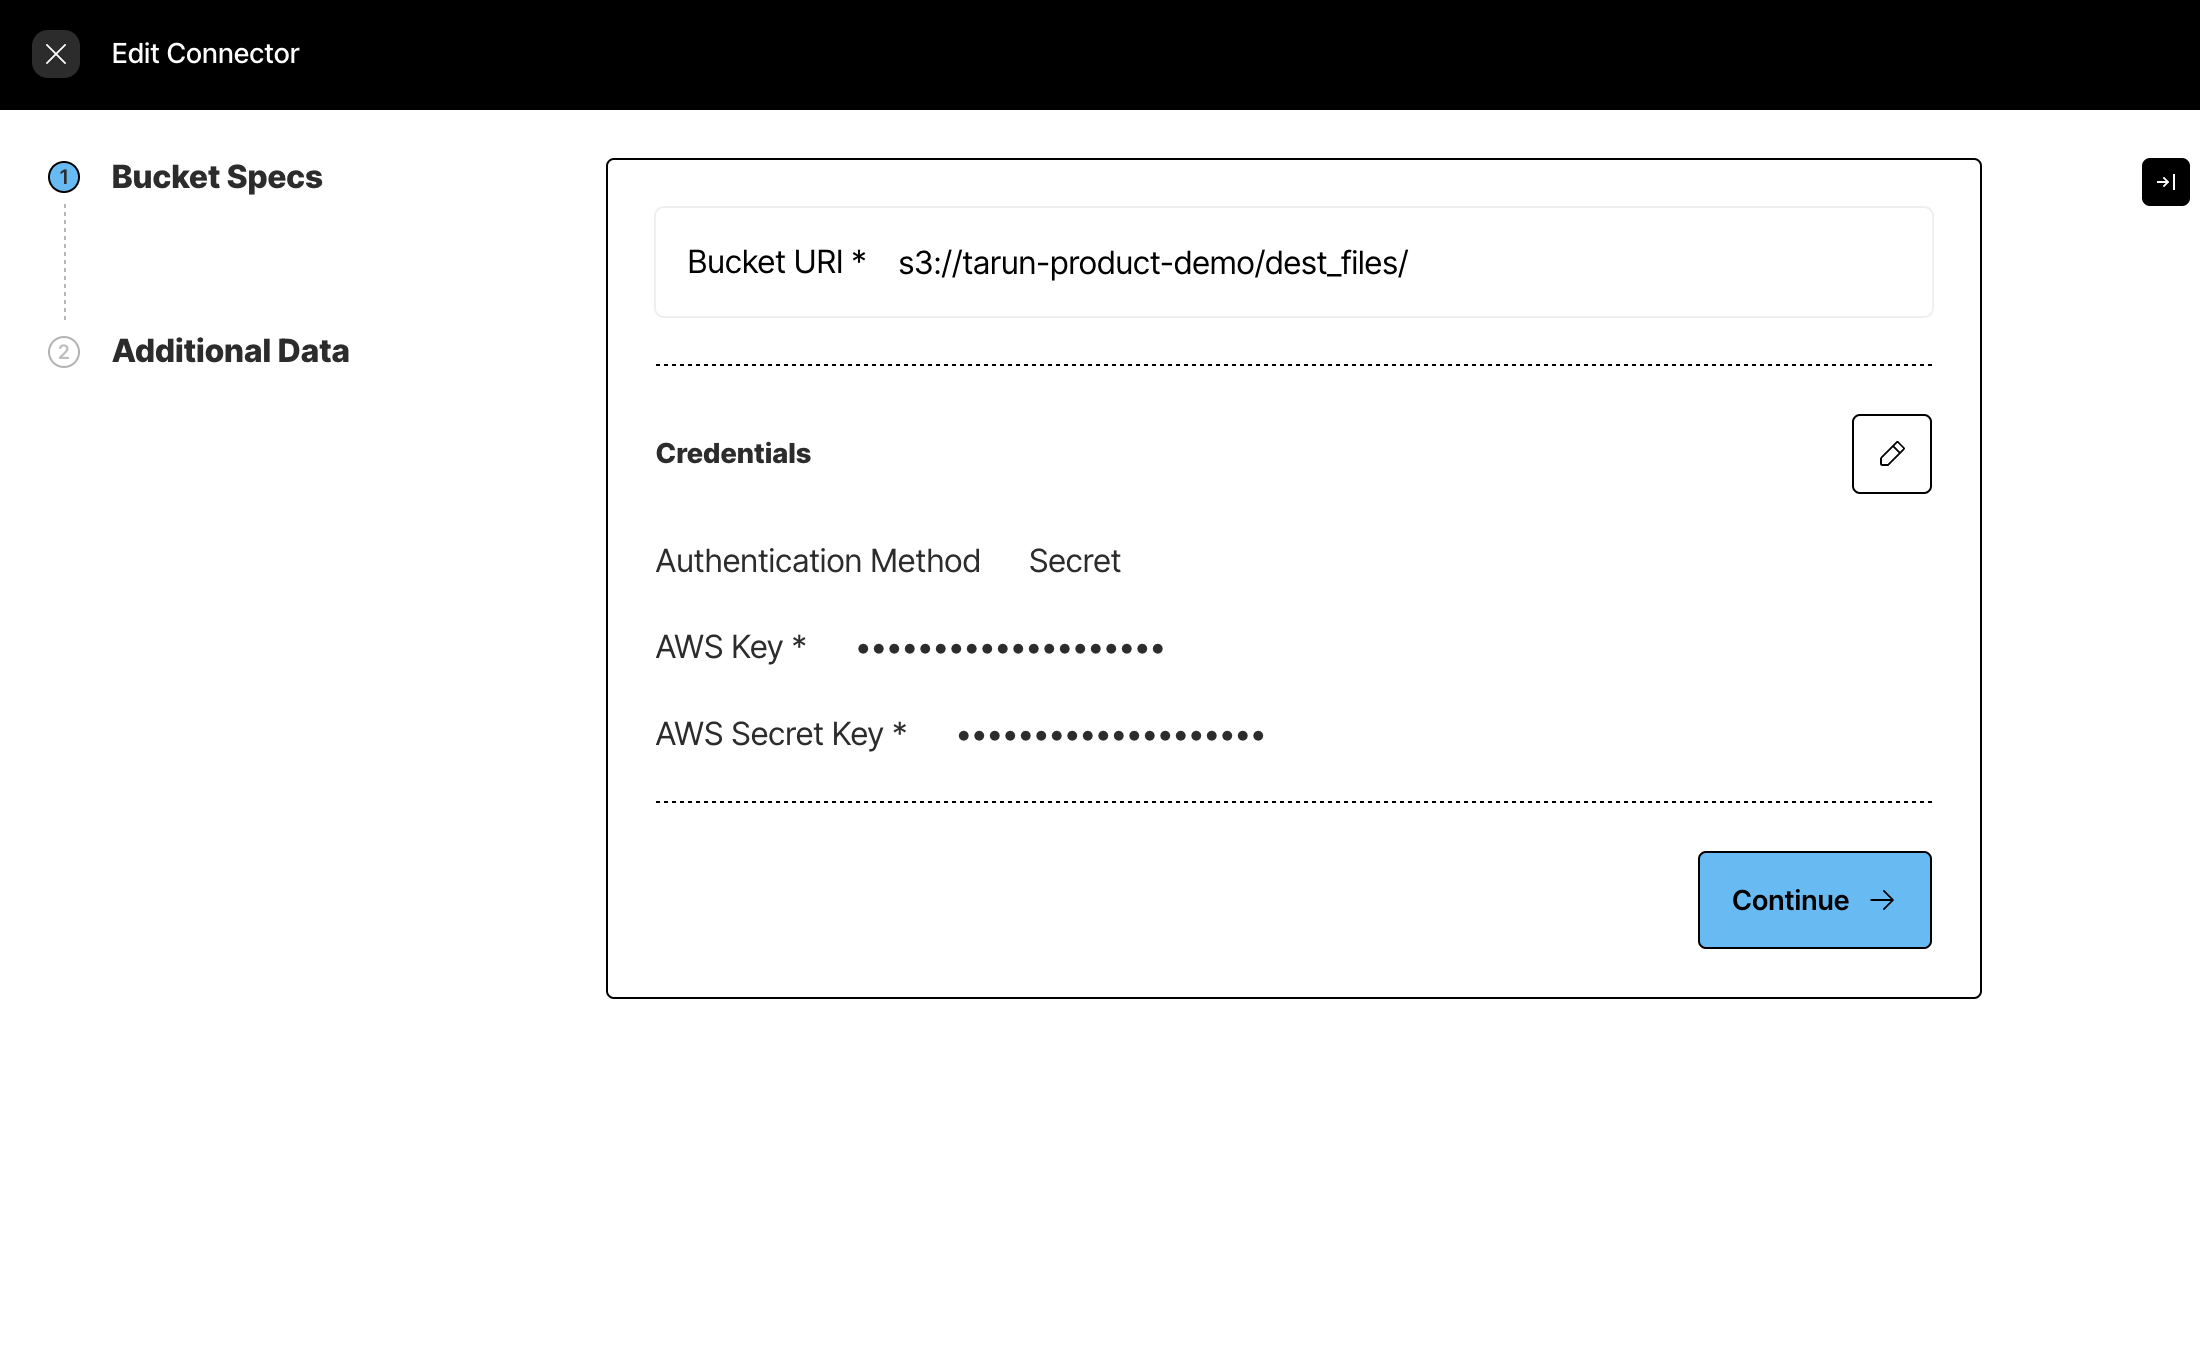

**Construct your workflow for document processing**



Select Workflows > New Workflow > Build it with Me



Select the source and destination connectors that we just created:


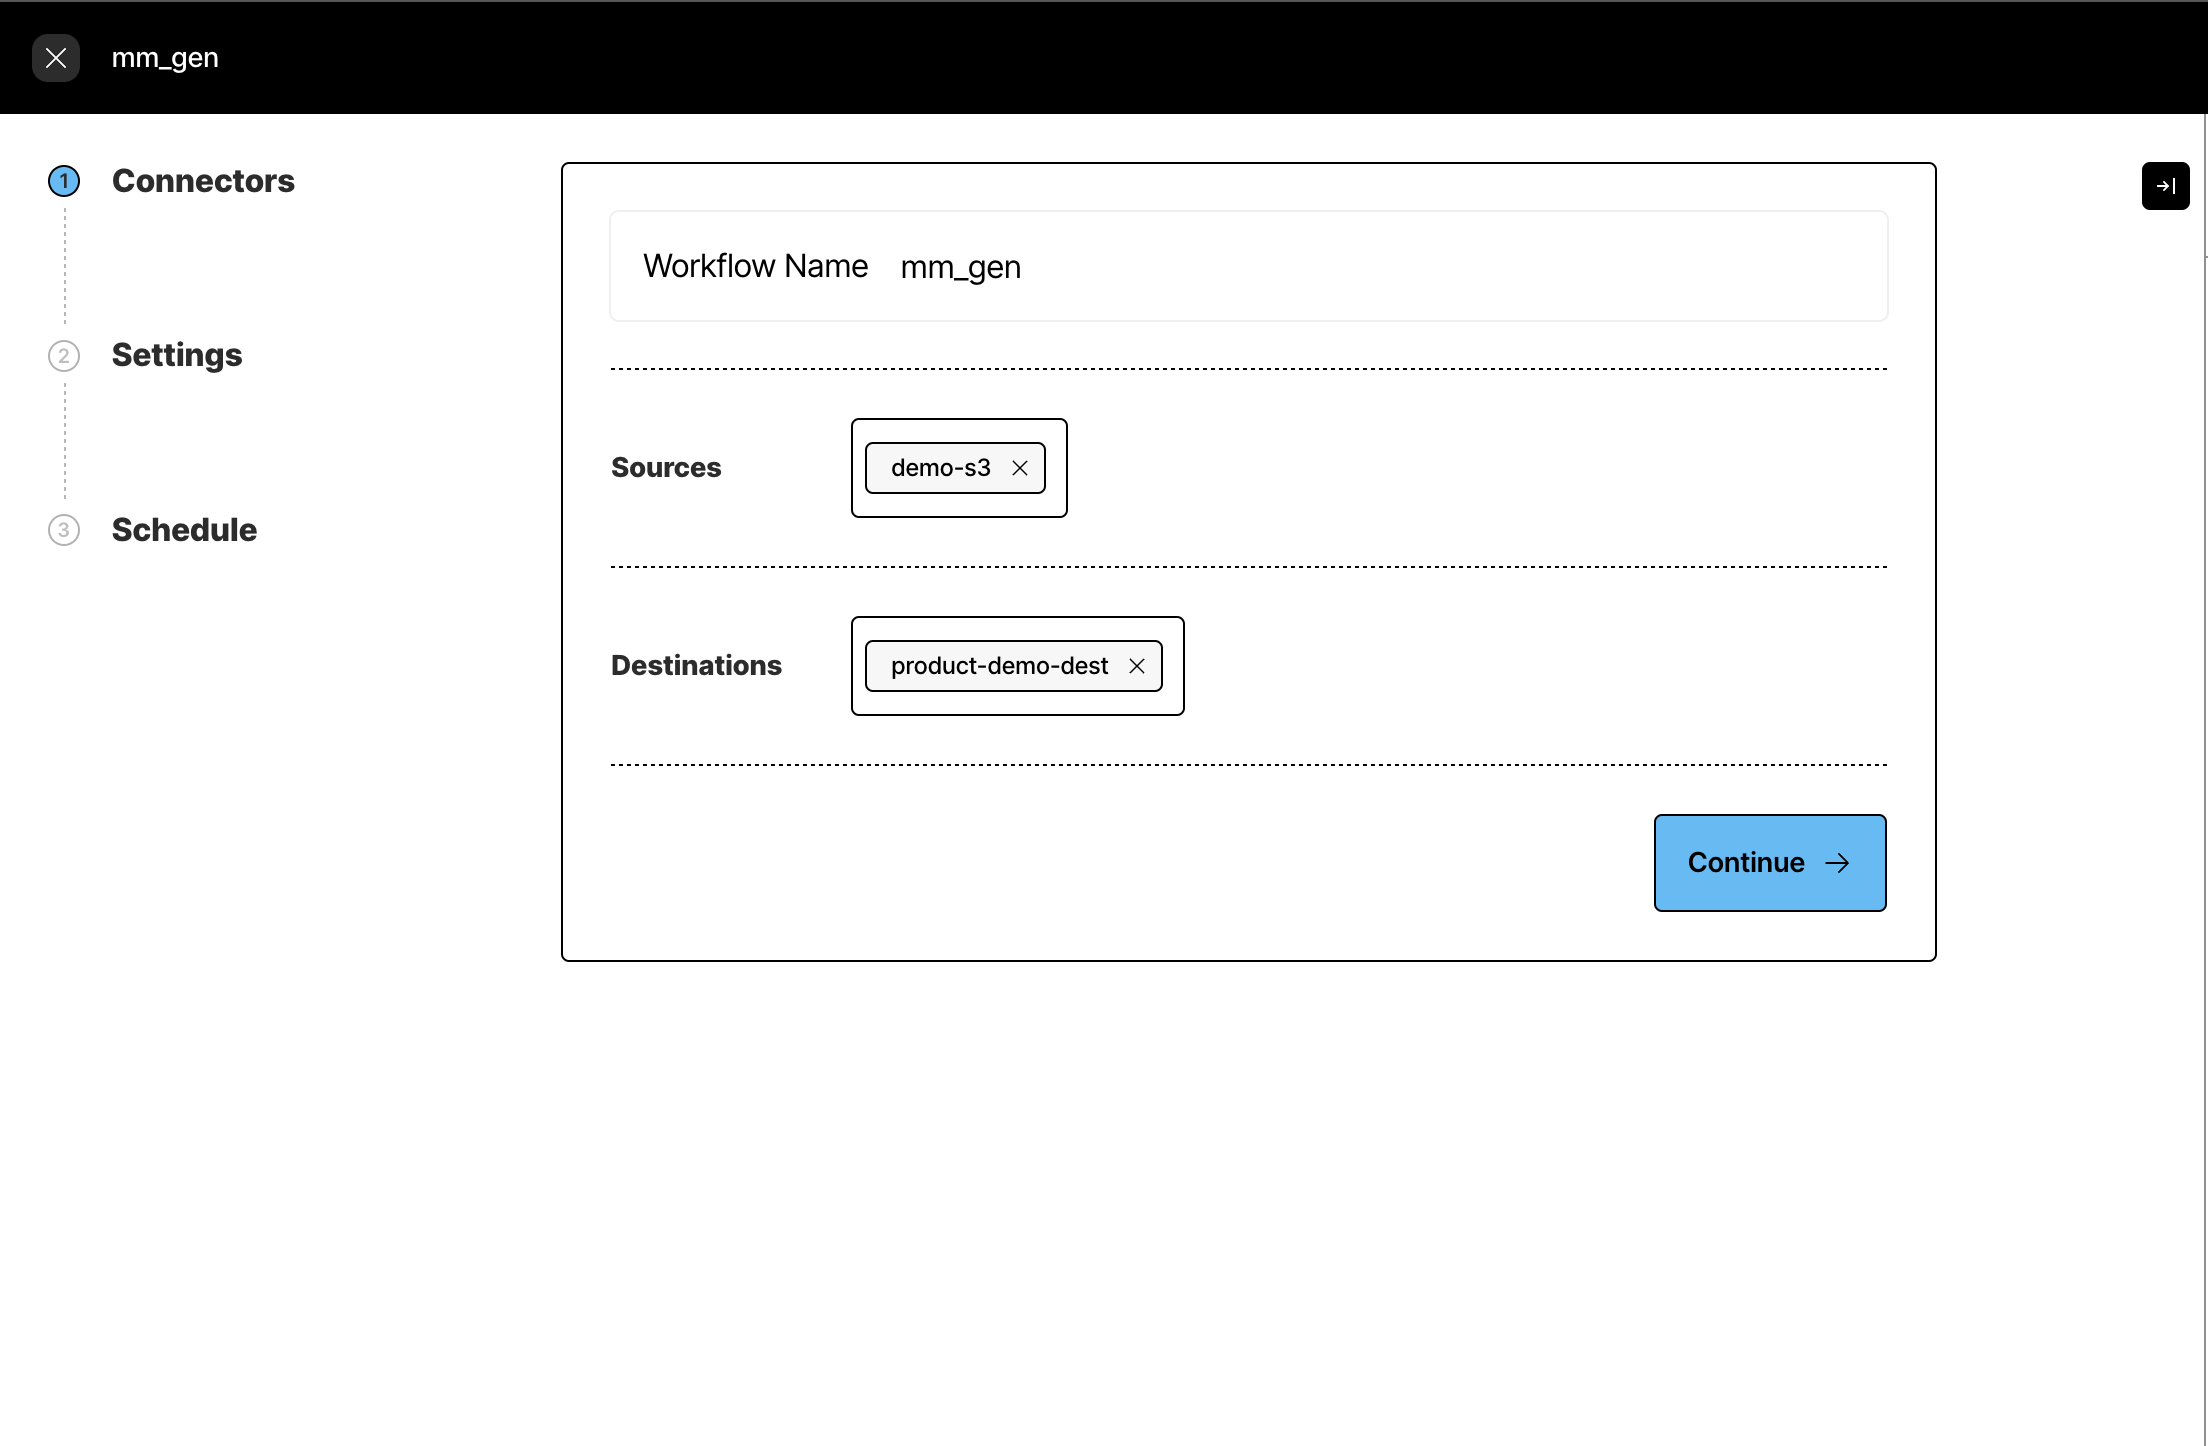

Then, we select custom to customize your workflow.


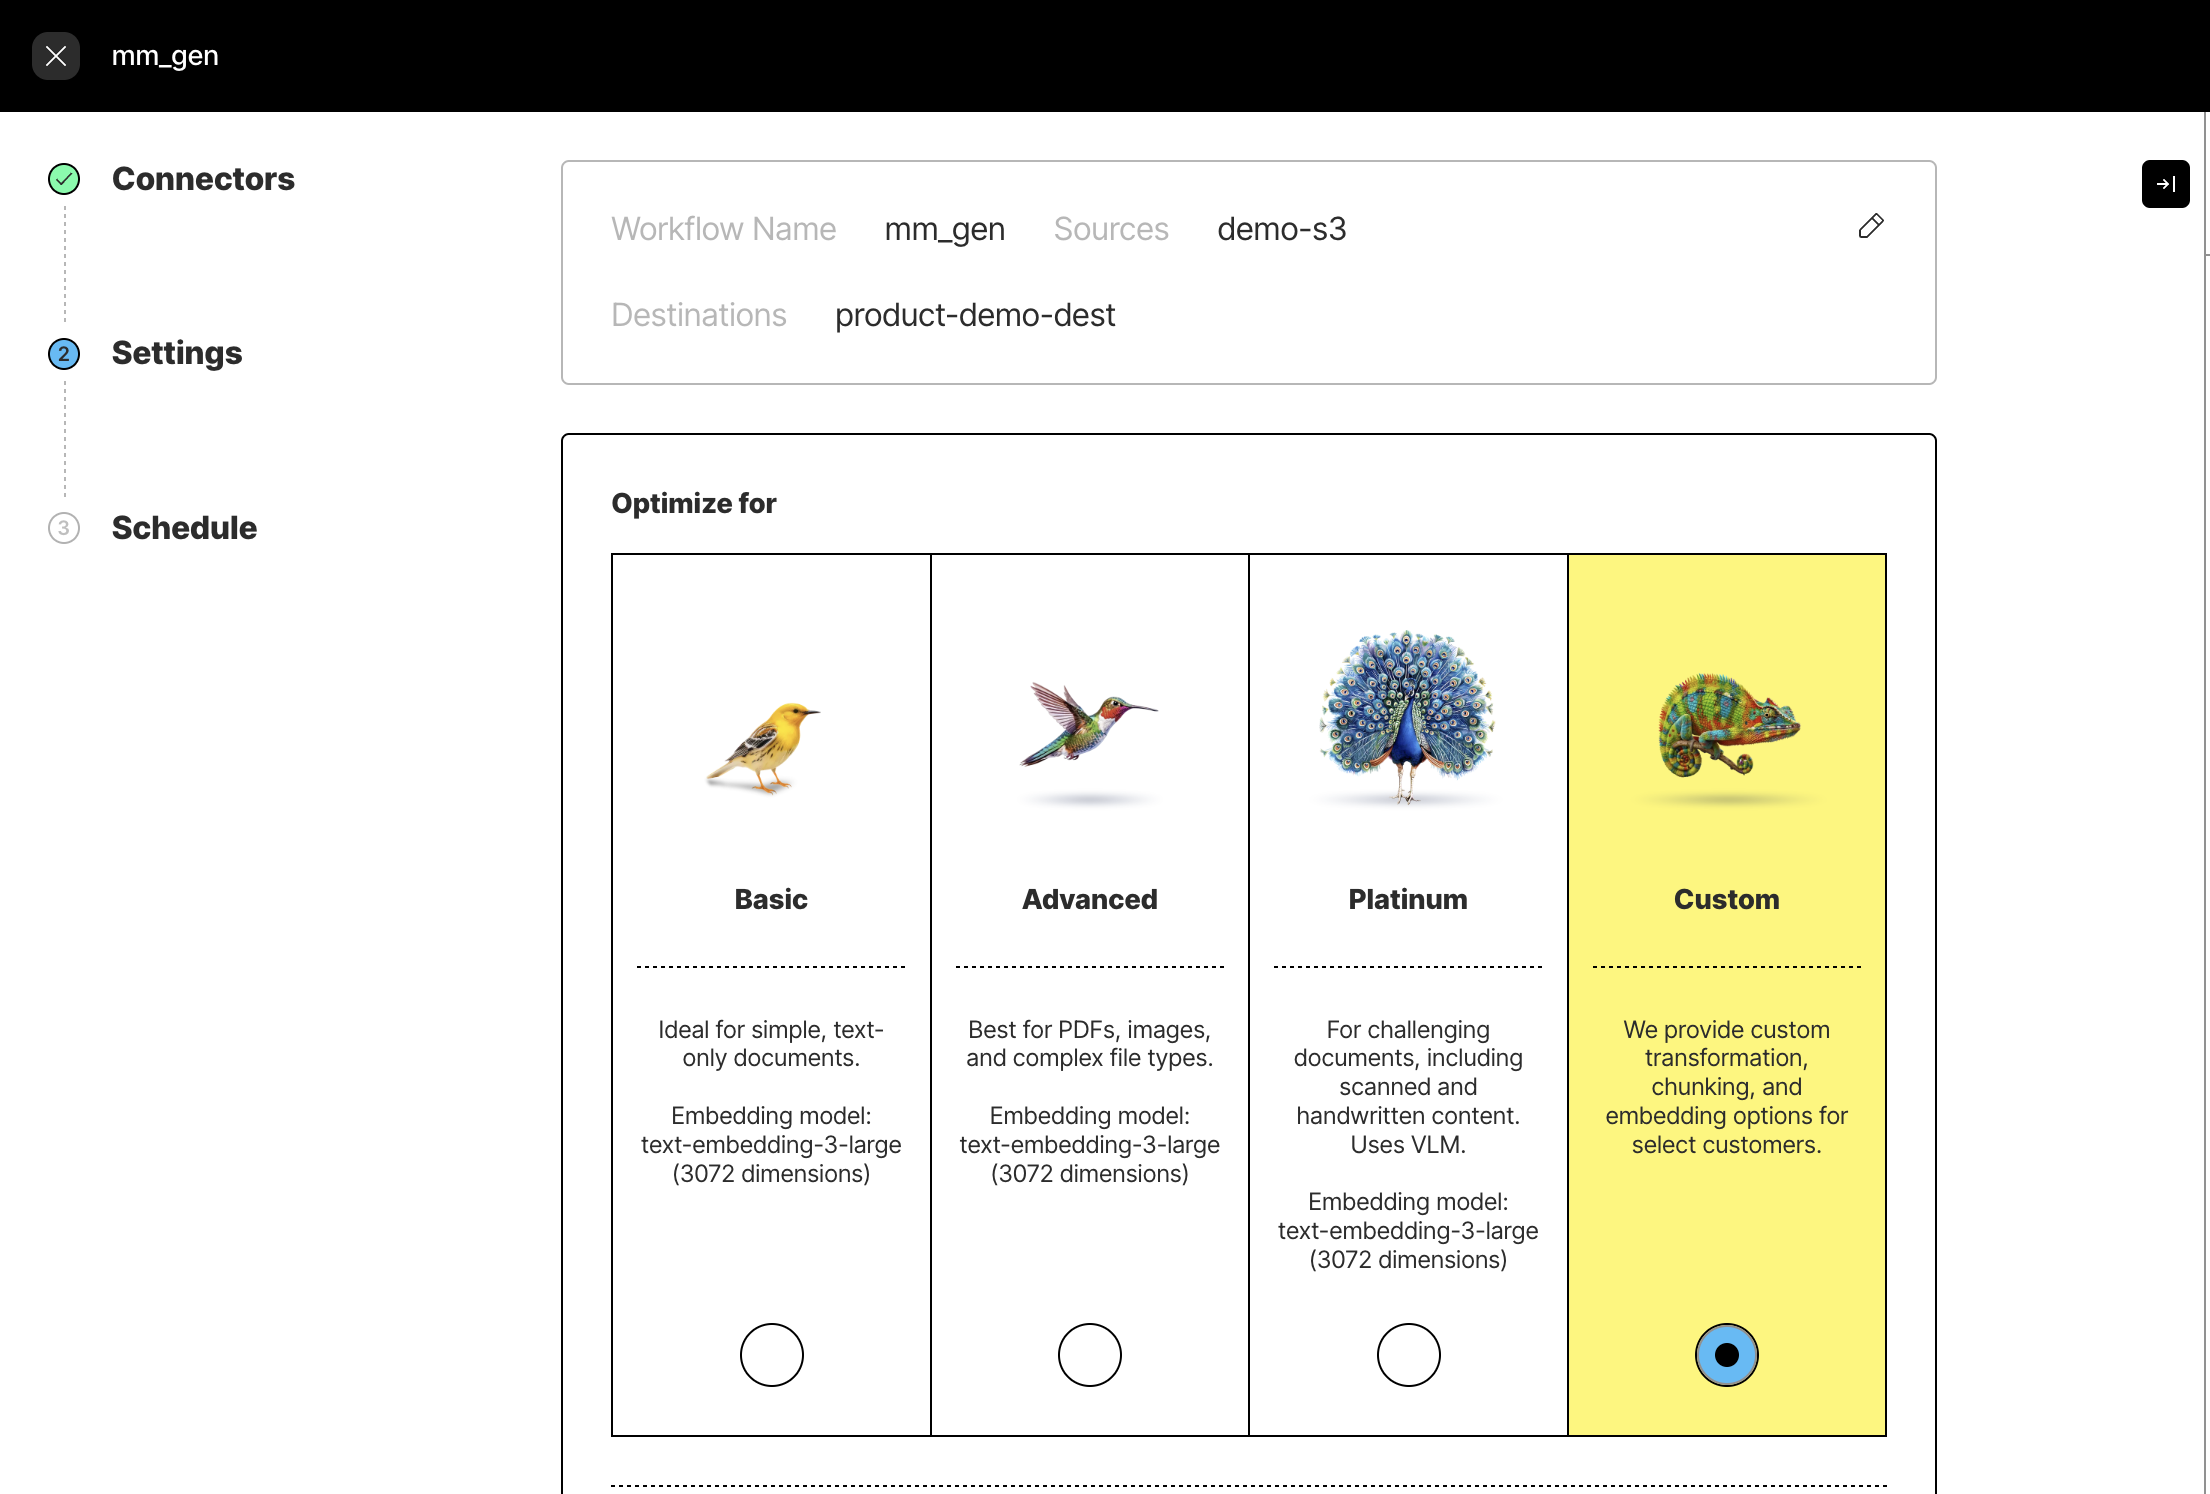

We are using the hi-res strategy since we are working with images.


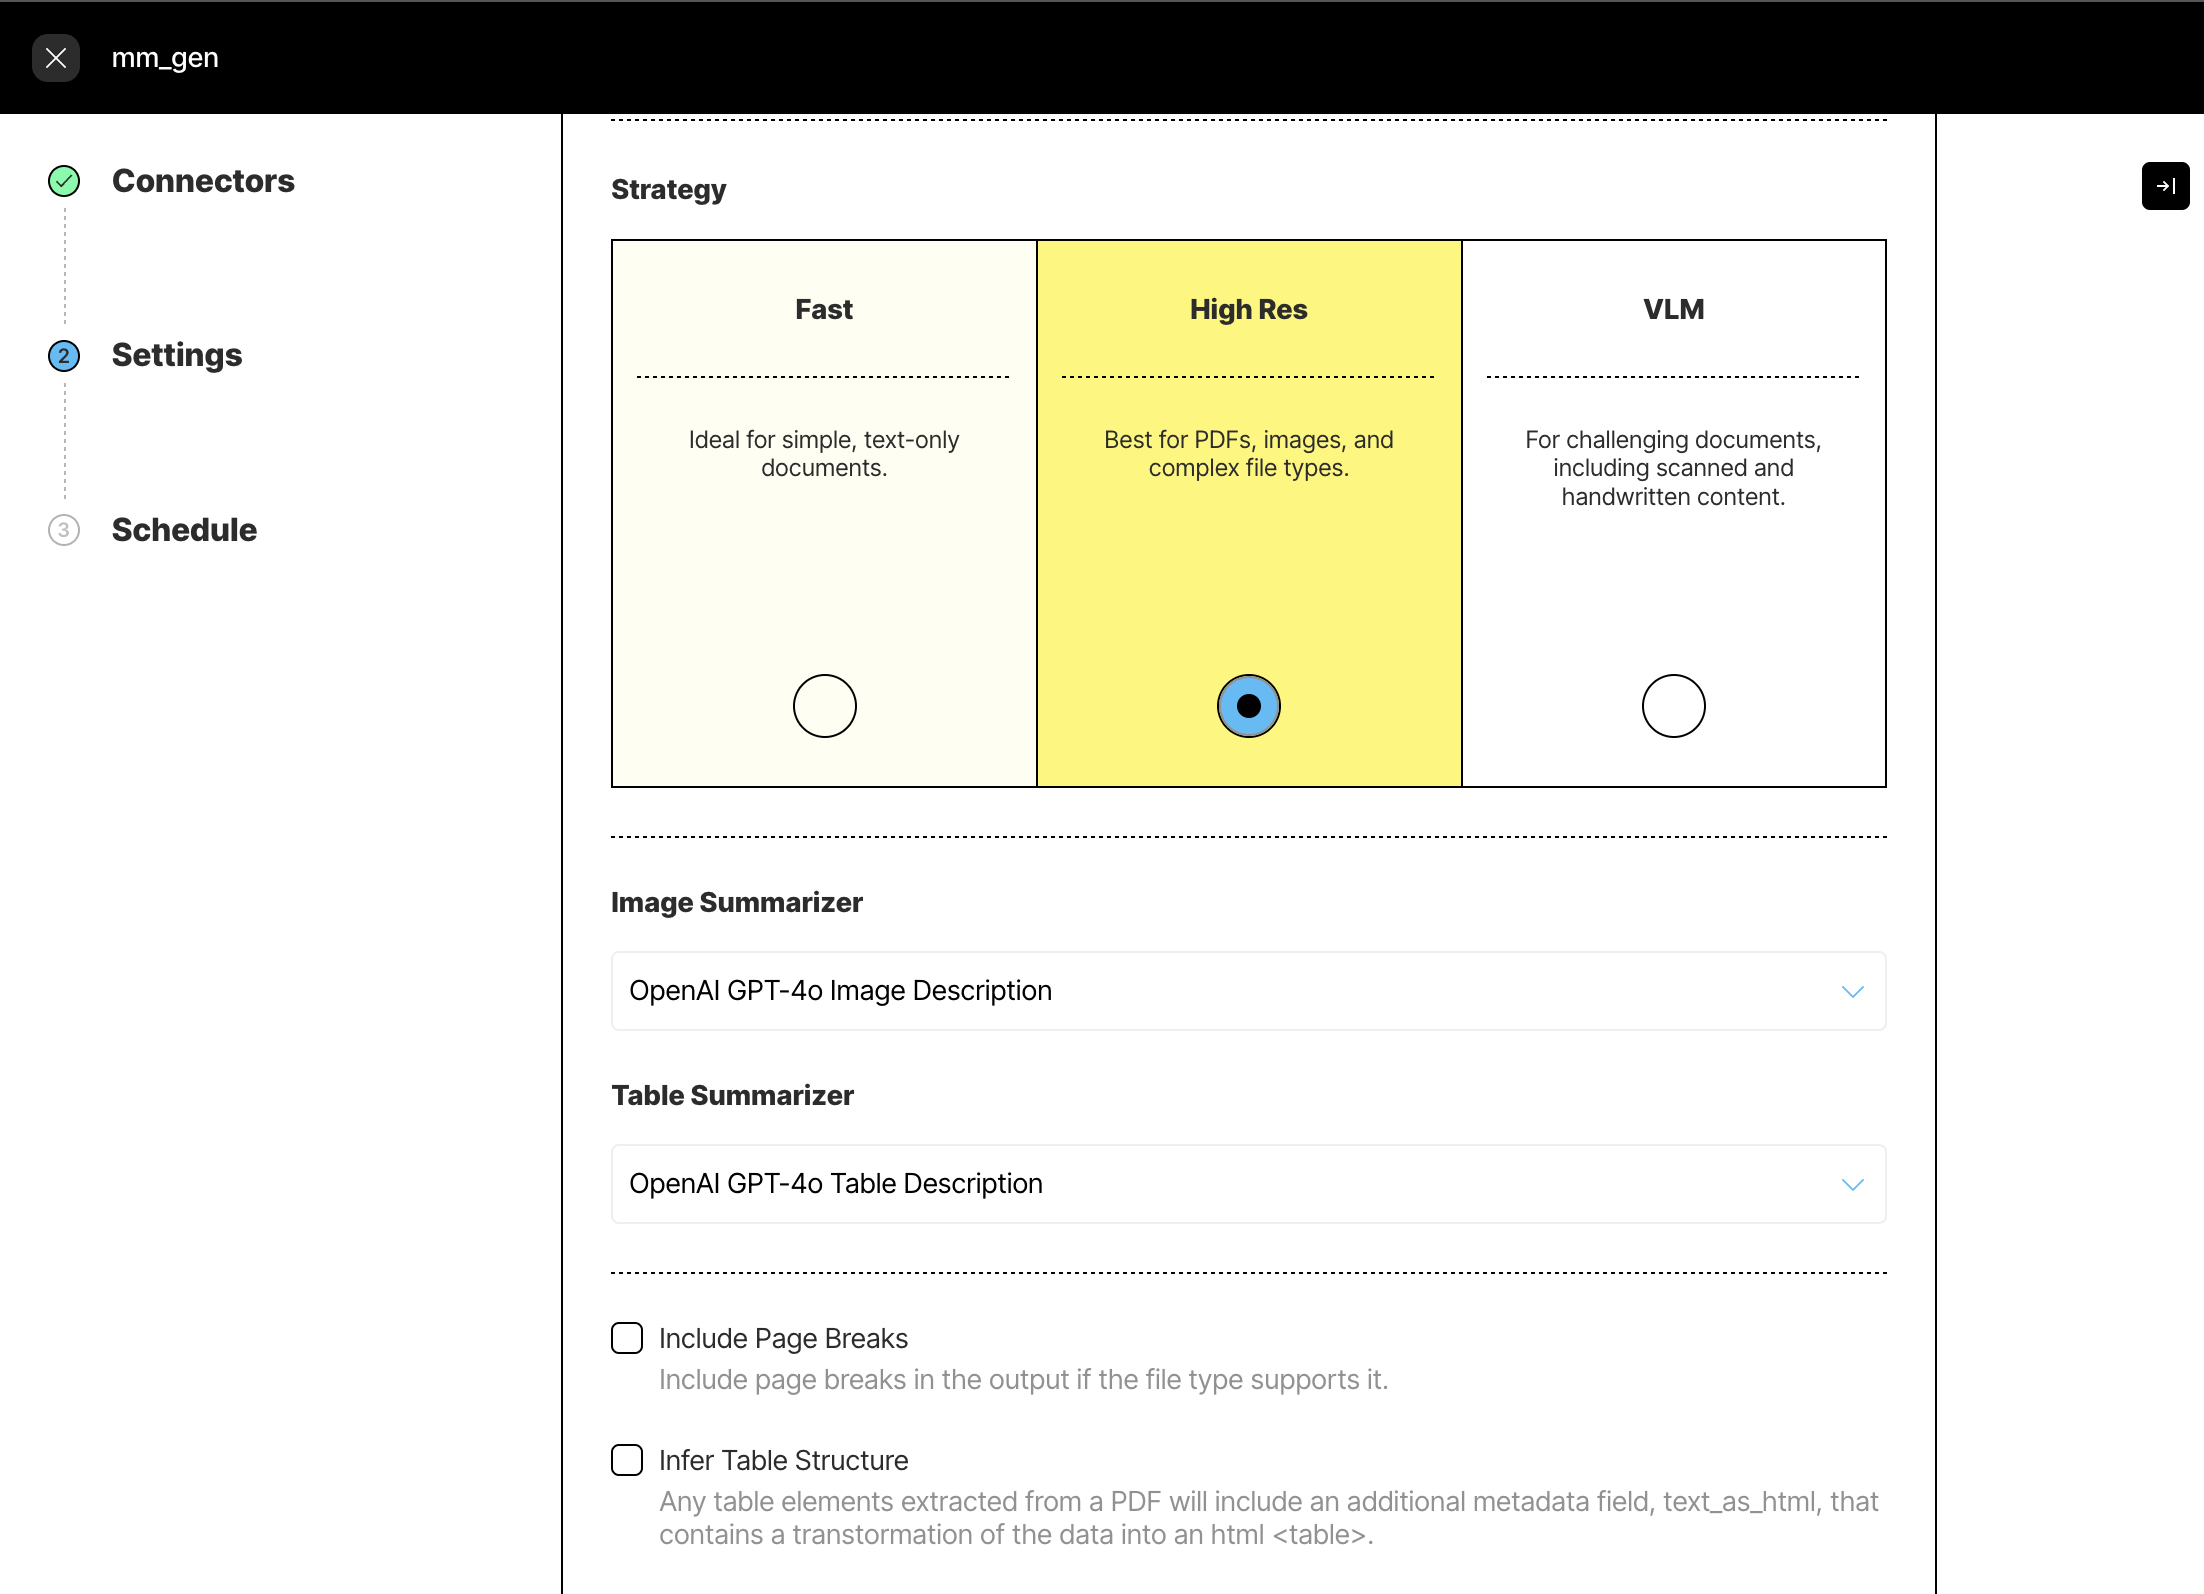

It is very important to select "Include Original Elements"!! This will maintain the metadata including base64 encoding for all images.

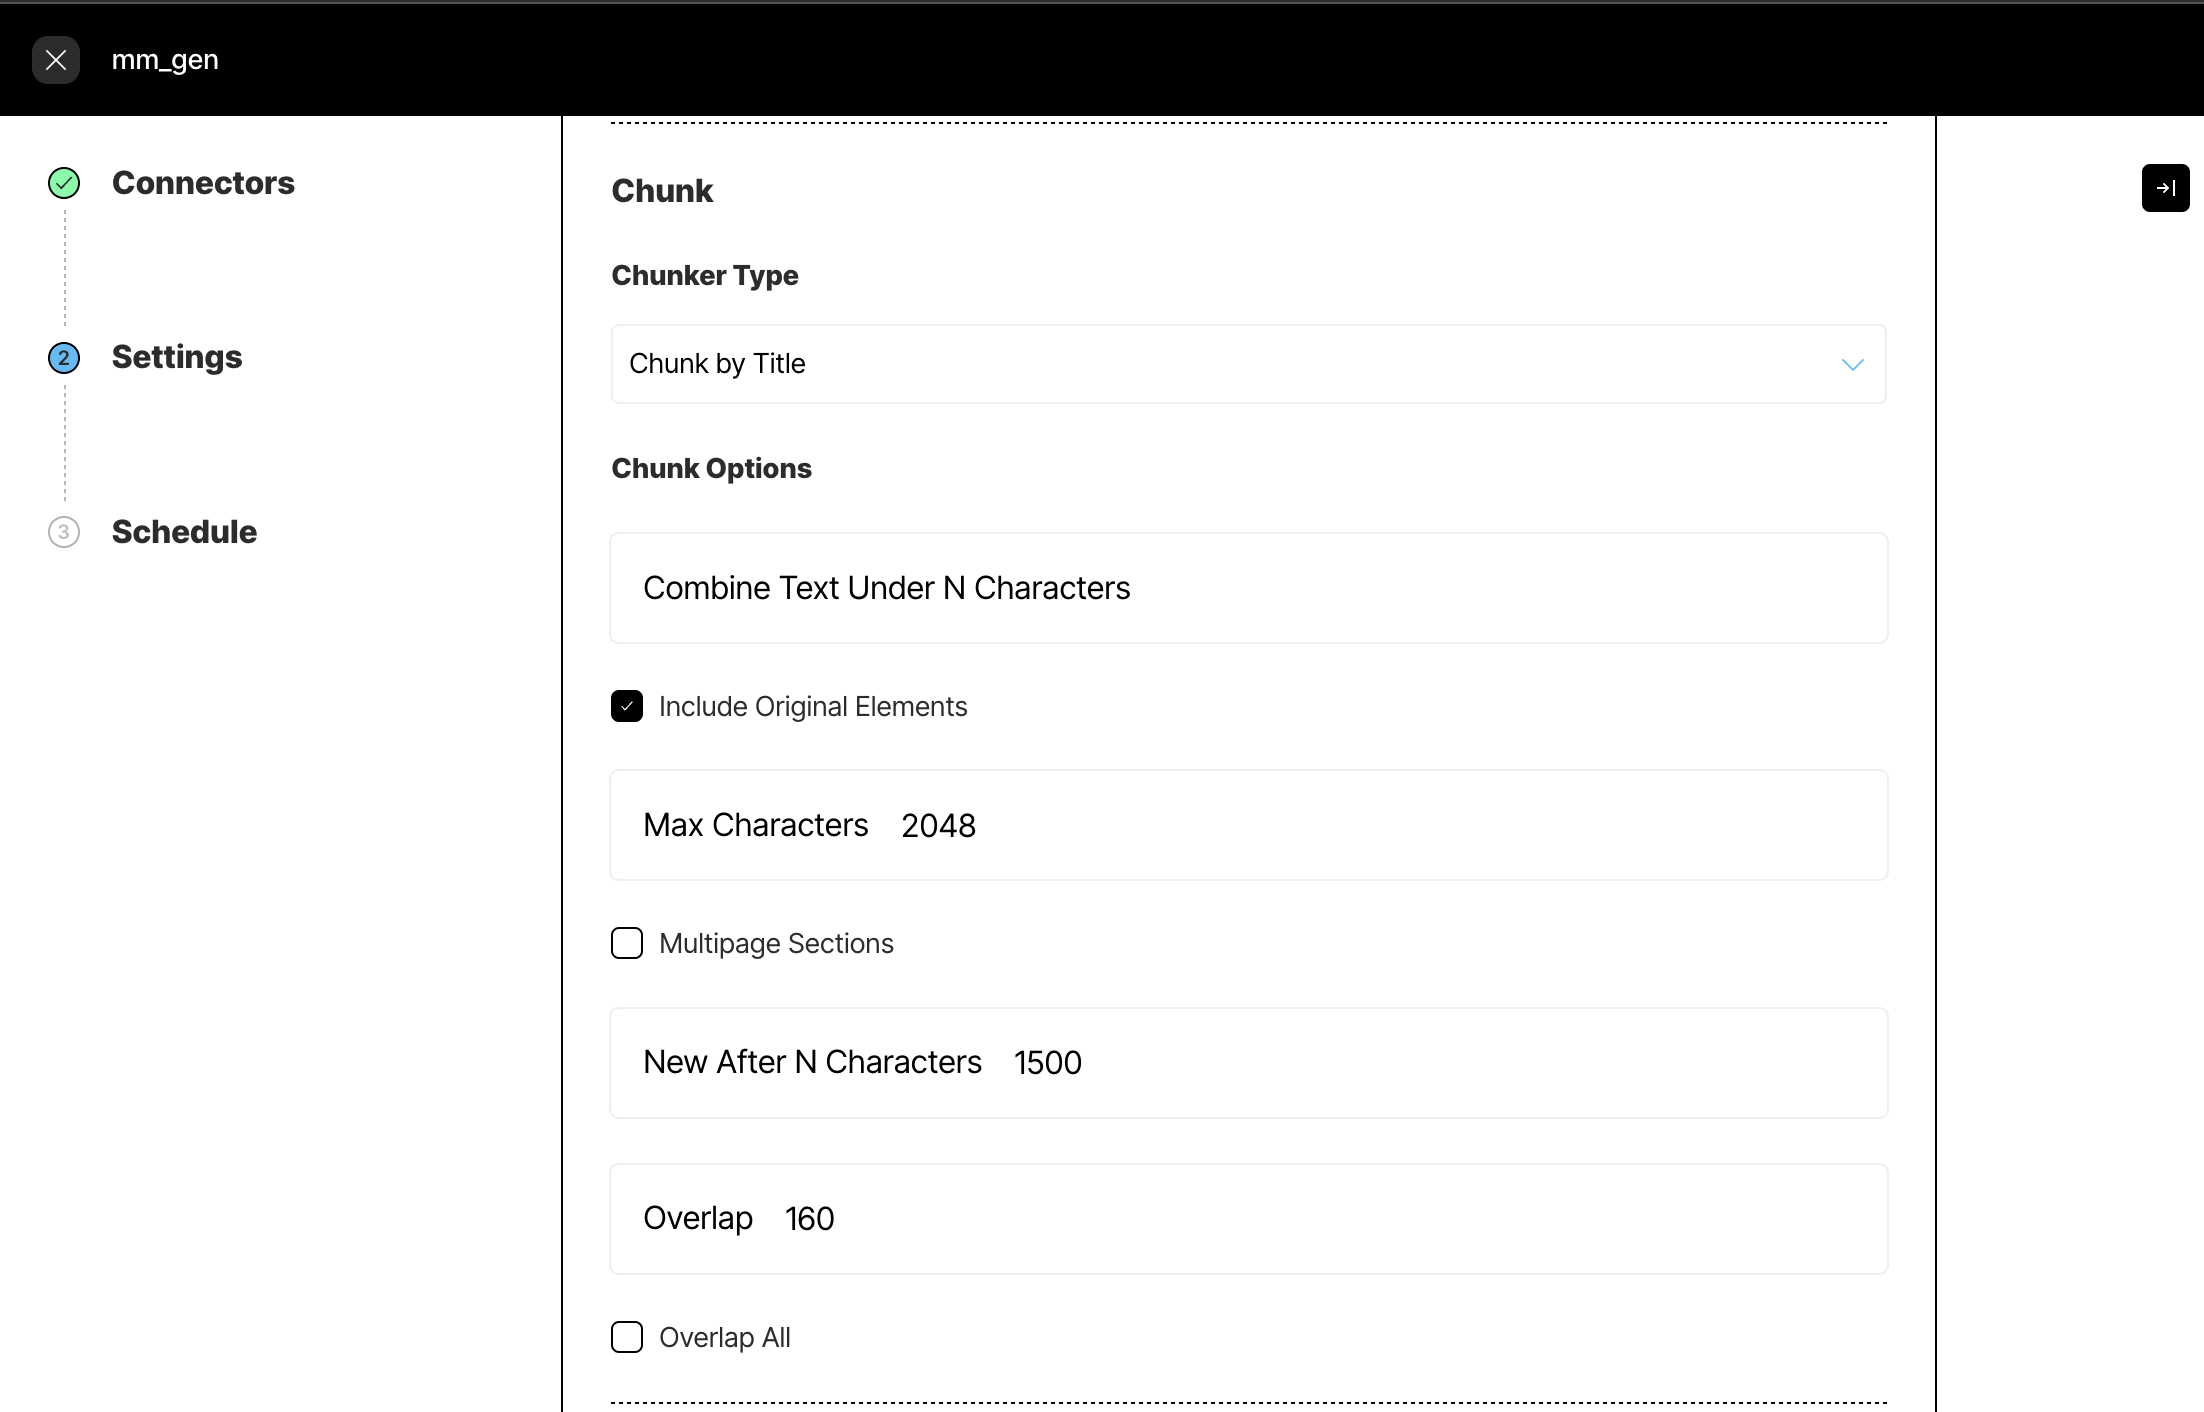

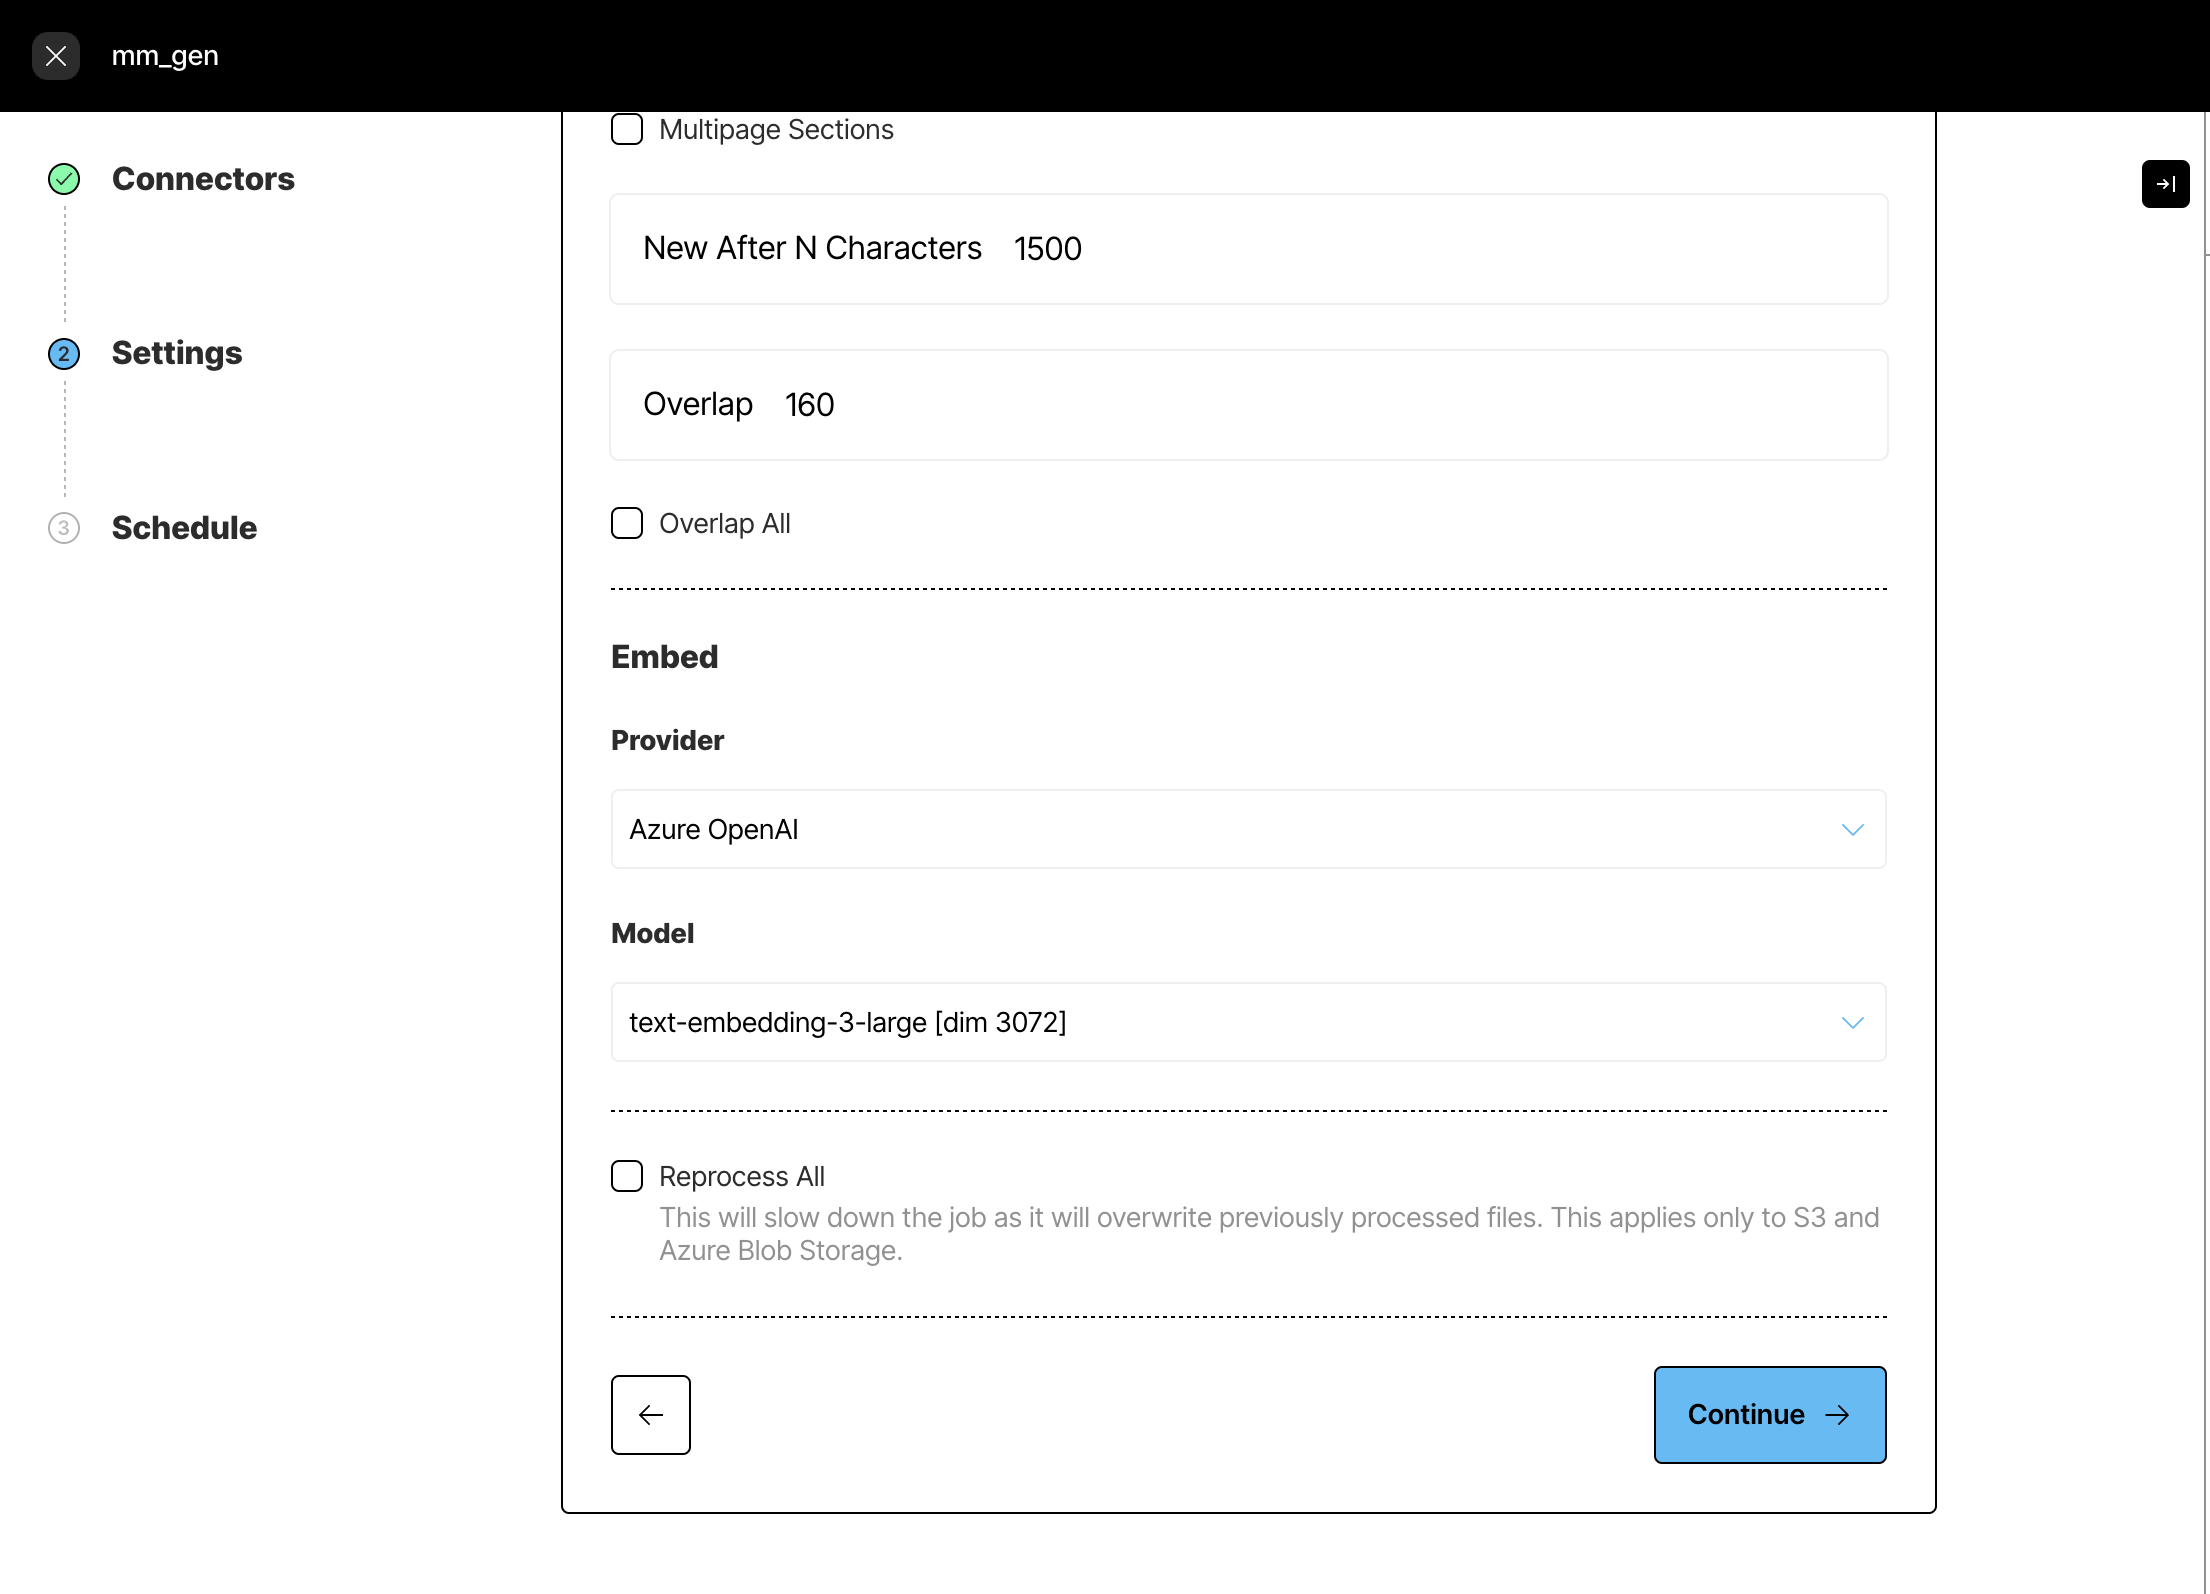

Let’s quickly review the parameters in this workflow creation form and what they mean:

**Strategy:**

- Basic / Fast is ideal for simple, text-only documents.
- Advanced / High Res is best for PDFs, images, and complex file types.
- Platinum / VLM is for challenging documents, including scanned and handwritten content.

**Image Summarizers:**

Generates a description of the image content
Example output includes details like image type, description of visual elements, and relevant metadata. This is key for our usecase.

**Table Summarizers:**

Provides a textual summary of table contents
Example output includes information about table structure, data trends, and key insights

**Chunk Options:**

This is where you can select the "Include Original Elements" option -- this is critical for keeping the original elements with their metadata, including base64 encoding of images

**Chunking Types:**

- Basic combines sequential elements up to specified size limits. Oversized elements are split, while tables are isolated and divided if necessary. Overlap between chunks is optional.

- By Title uses semantic chunking, understands the layout of the document, and makes intelligent splits.

- By Page attempts to preserve page boundaries when determining the chunks’ contents.

- By Similarity uses an embedding model to identify topically similar sequential elements and combines them into chunks.

**Embed**

The Unstructured Platform uses optional third-party embedding providers such as OpenAI to generate semantically relevant embeddings on the extracted text.


This is the recommended way of setting up a workflow - granularly tuning every setting based on your data. If you want something quicker, you could also select one of the preset options available on the platform fast, hi-res and VLM to get started.

Finally, select the schedule at which you want to run this workflow.


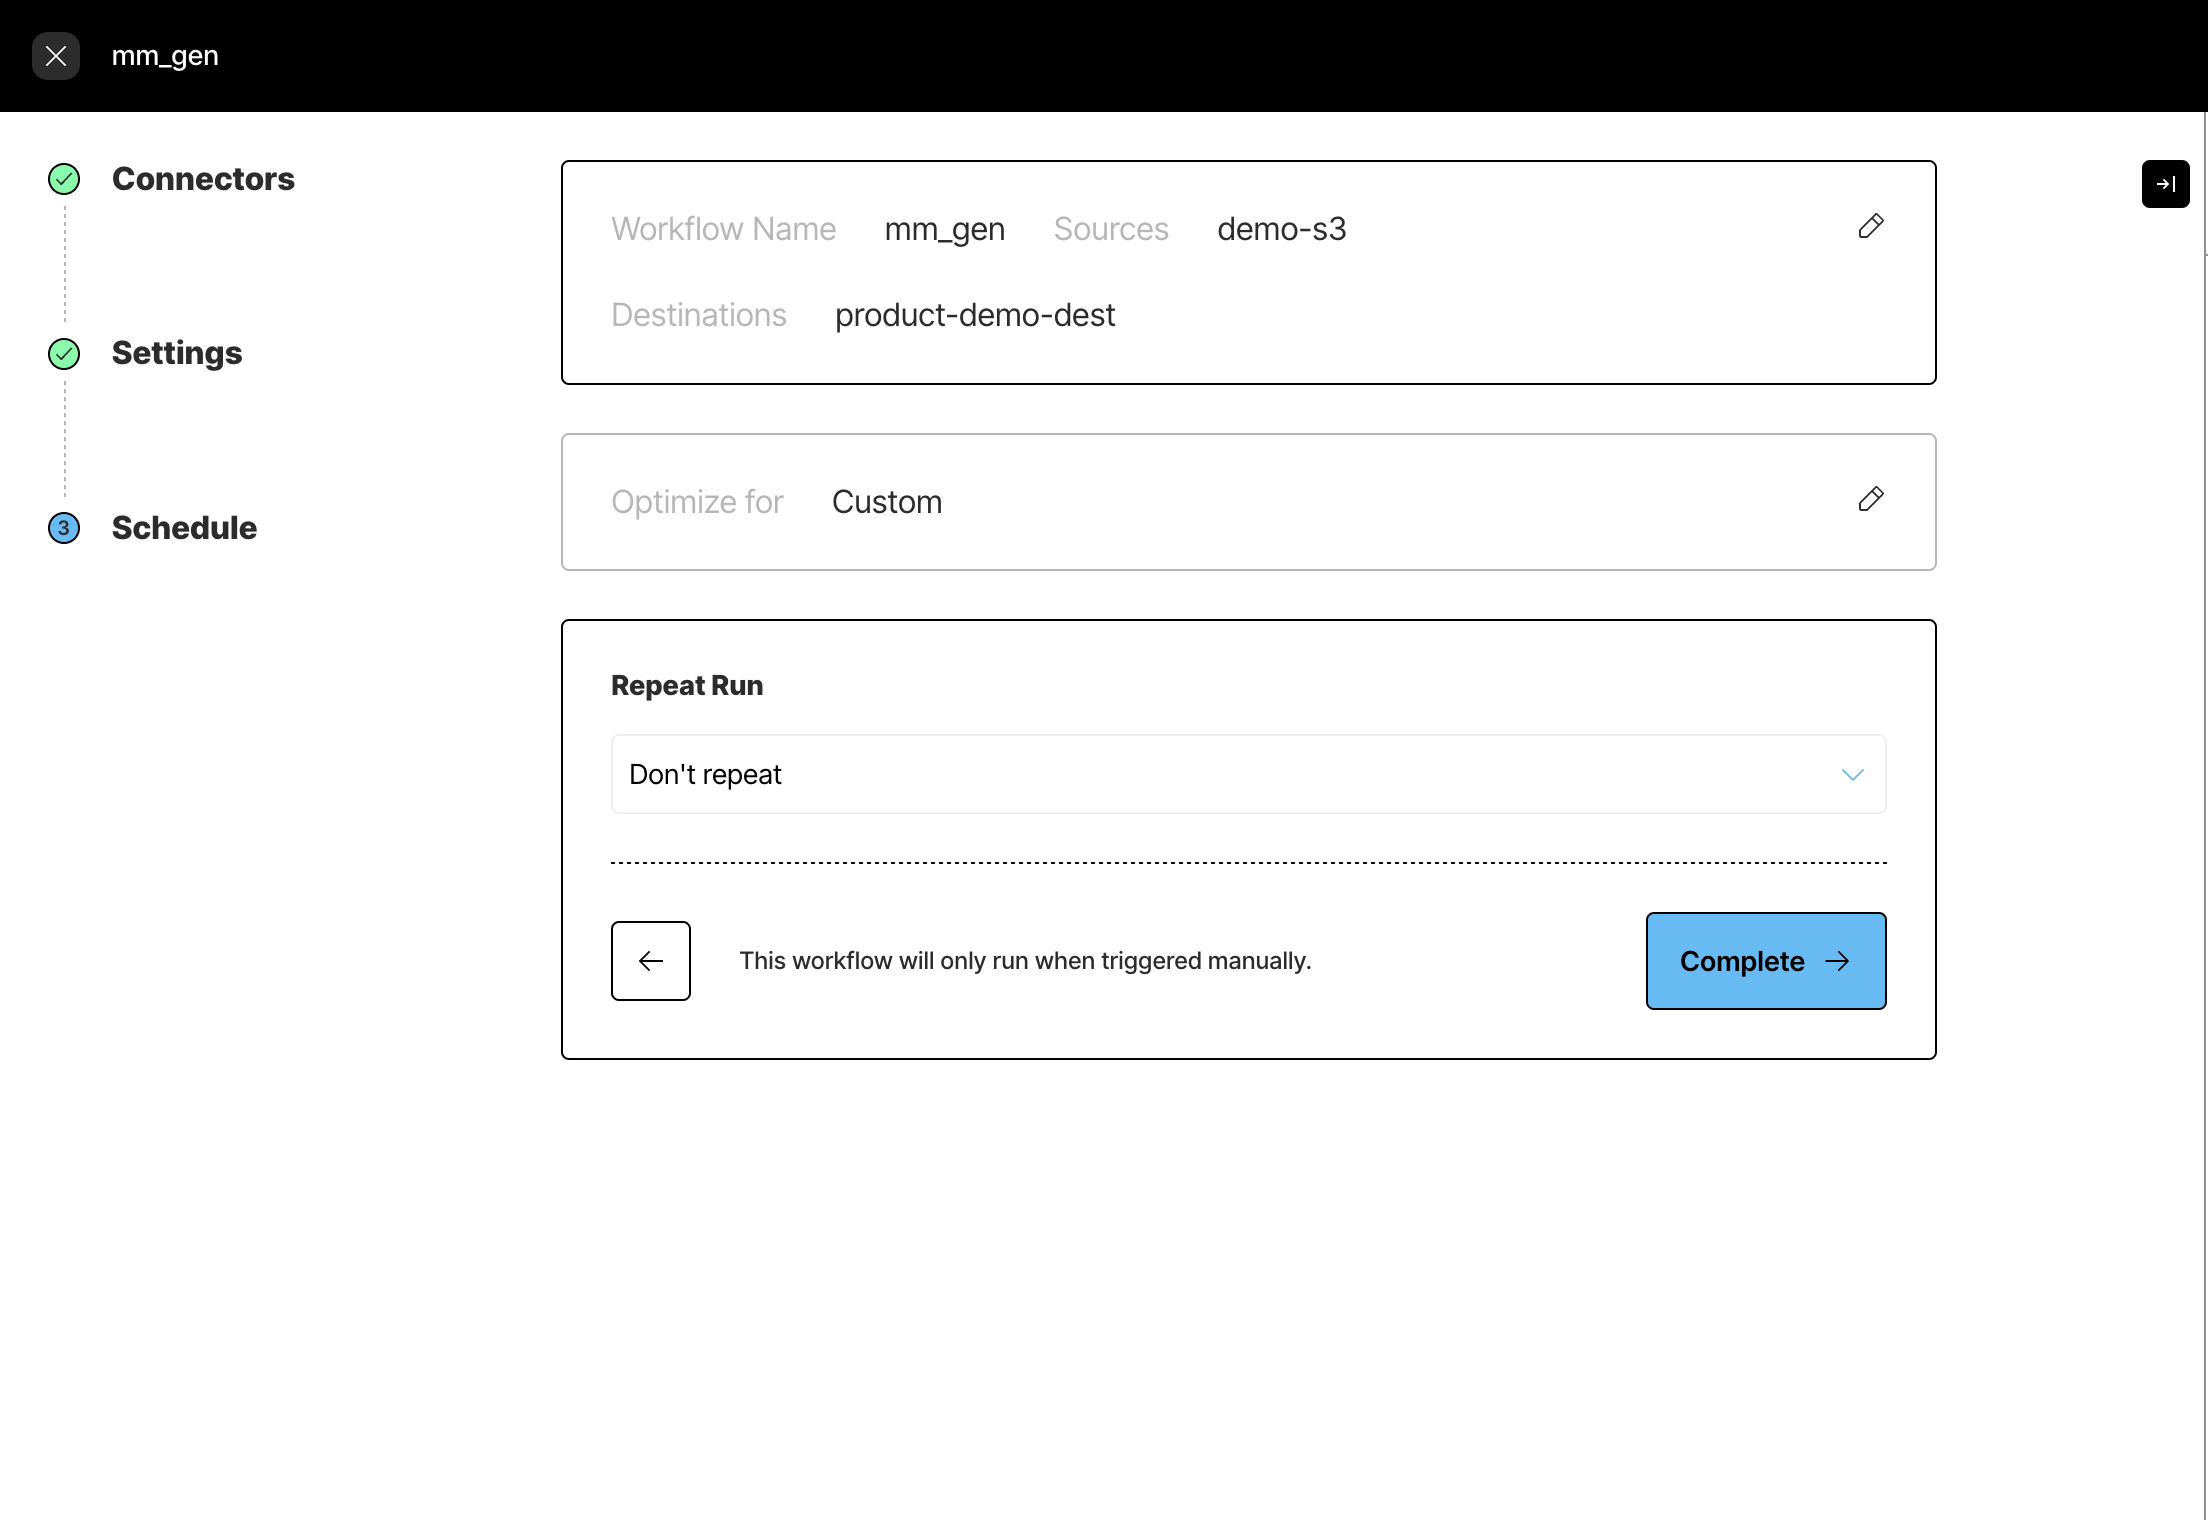

Our workflow is ready!

On the workflows page you should find the workflow you just created like this:


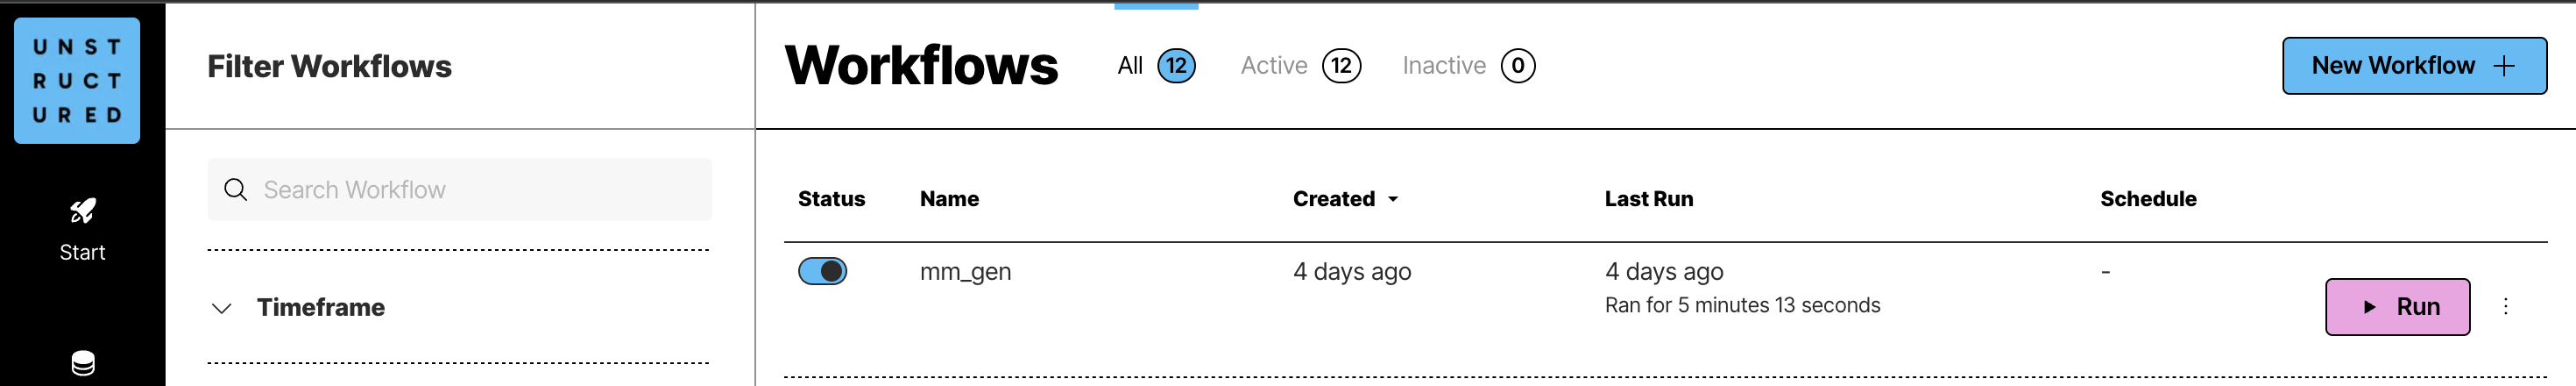

Simply hit "Run" to kick off the ETL workflow, and watch as your documents are processed automatically from start to finish.


You can monitor the progress of your workflow under the jobs pane.


## Platform Output


Once the worflow has completed running, we can fetch the output JSON from the destination S3 bucket.




In [ ]:
# Download the output JSON generated by our platform from our destination (S3)

!wget https://tarun-product-demo.s3.us-east-1.amazonaws.com/dest_files/jalammar-github-io-illustrated-transformer-.pdf.json

--2024-12-13 09:03:19--  https://tarun-product-demo.s3.us-east-1.amazonaws.com/dest_files/jalammar-github-io-illustrated-transformer-.pdf.json
Resolving tarun-product-demo.s3.us-east-1.amazonaws.com (tarun-product-demo.s3.us-east-1.amazonaws.com)... 16.15.178.102, 3.5.30.236, 52.216.216.170, ...
Connecting to tarun-product-demo.s3.us-east-1.amazonaws.com (tarun-product-demo.s3.us-east-1.amazonaws.com)|16.15.178.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3495046 (3.3M) [application/json]
Saving to: ‘jalammar-github-io-illustrated-transformer-.pdf.json’

jalammar-github-io- 100%[===================>]   3.33M  9.25MB/s    in 0.4s    

2024-12-13 09:03:20 (9.25 MB/s) - ‘jalammar-github-io-illustrated-transformer-.pdf.json’ saved [3495046/3495046]



# RAG w/ FAISS

The `RAGSystem` class is a naive RAG implementation that combines FAISS for similarity search and OpenAI's models for embedding and response generation.

It also contains the logic to store and retrieve the corresponding images and image descriptions for the retreived chunks.

We are using FAISS here as a quick demo of how to use this on one file, but we recommend using one of our many [destination connectors](https://docs.unstructured.io/platform/destinations/overview) for a production workflow.

In [ ]:
class RAGSystem:
    def __init__(self, embedding_dimension: int = 3072):
        """
        Initialize the RAG system with FAISS index and OpenAI client.

        Args:
            embedding_dimension: Dimension of the embeddings (1536 for OpenAI embeddings)
        """
        self.client = OpenAI()
        self.index = faiss.IndexFlatL2(embedding_dimension)
        self.uuid_metadata_map = {}
        self.id_to_text_map = {}

    def extract_dictionaries_from_text(self, text: str) -> List[Dict]:
        """
        Extract all valid JSON-like dictionaries from a given string.

        Args:
            text: The input string containing text and potential JSON dictionaries

        Returns:
            List of successfully parsed dictionaries
        """
        pattern = r'\{.*?\}'
        matches = re.findall(pattern, text)

        extracted_dicts = []
        for match in matches:
            try:
                extracted_dict = json.loads(match)
                extracted_dicts.append(extracted_dict)
            except json.JSONDecodeError:
                pass

        return extracted_dicts

    def get_embedding(self, text: str) -> np.ndarray:
        """
        Get embedding for text using OpenAI's API.

        Args:
            text: Input text to embed

        Returns:
            Numpy array of embedding
        """

        emb_client = OpenAI()
        response = emb_client.embeddings.create(
            model="text-embedding-3-large",
            input=text
        )
        return np.array(response.data[0].embedding, dtype=np.float32)

    def ingest_entries(self, entries: List[Dict]):
        """
        Ingest entries into the FAISS index and metadata map.

        Args:
            entries: List of dictionaries containing text and metadata
        """
        embeddings = []
        ids = []

        for item in entries:
            # Generate UUID for the entry
            node_id = str(uuid.uuid4())

            # Get or compute embedding
            if 'embeddings' in item:
                embedding = np.array(item['embeddings'], dtype=np.float32)
            else:
                embedding = self.get_embedding(item['text'])

            embeddings.append(embedding)
            ids.append(node_id)

            # Extract image descriptions
            img_desc = self.extract_dictionaries_from_text(item['text'])

            # Store metadata
            self.uuid_metadata_map[node_id] = {
                'img_desc': img_desc,
                'img_b64': []
            }

            # Store text for retrieval
            self.id_to_text_map[node_id] = item['text']

            # Process base64 images if present
            """
            This is where we leverage the elements_from_base64_gzipped_json
            function in the Unstructured library, to recreate our original
            elements. To extract the metadata containing base64 encoding.
            """
            if 'metadata' in item and 'orig_elements' in item['metadata']:
                for ele in base.elements_from_base64_gzipped_json(item['metadata']['orig_elements']):
                    ele_dict = ele.to_dict()
                    if ele_dict['type'] == "Image":
                        self.uuid_metadata_map[node_id]['img_b64'].append(
                            ele_dict['metadata']['image_base64']
                        )

        # Add embeddings to FAISS index
        embeddings_array = np.vstack(embeddings).astype('float32')
        self.index.add(embeddings_array)

    def query(self, query_text: str, top_k: int = 5) -> Dict:
        """
        Process a query and return relevant results with images.

        Args:
            query_text: The query string
            top_k: Number of top results to retrieve

        Returns:
            Dictionary containing response and retrieved data
        """
        # Get query embedding
        query_embedding = self.get_embedding(query_text)

        # Search FAISS index
        D, I = self.index.search(
            np.array([query_embedding]).astype('float32'),
            top_k
        )

        # Collect retrieved texts
        retrieved_texts = []
        retrieved_data = []

        for idx in I[0]:
            node_id = list(self.uuid_metadata_map.keys())[idx]
            text = self.id_to_text_map[node_id]
            retrieved_texts.append(text)
            # Add the base64 encoded images to relevant text
            retrieved_data.append({
                'text': text,
                'image_base64': self.uuid_metadata_map[node_id]['img_b64'],
                'image_desc': self.uuid_metadata_map[node_id]['img_desc']
            })

        # Generate RAG response using OpenAI
        context = "\n\n".join(retrieved_texts)
        response = self.client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context."},
                {"role": "user", "content": f"Given the query: {query_text}\n\nUse this context to answer the question in a concise, informative way:\n\n{context}"}
            ]
        )

        # Process images and descriptions
        combined_data = []
        for entry in retrieved_data:
            b64_list = entry['image_base64']
            desc_list = [x['description'] for x in entry['image_desc']]
            combined_data.extend(zip(b64_list, desc_list))

        # Remove duplicates while preserving order
        unique_combined_data = list(OrderedDict((b64, desc) for b64, desc in combined_data).items())
        unique_b64 = [item[0] for item in unique_combined_data]
        unique_desc = [item[1] for item in unique_combined_data]

        return {
            'response': response.choices[0].message.content,
            'images': unique_b64,
            'descriptions': unique_desc
        }

    def display_results(self, results: Dict):
        """
        Display the results including text response and images.

        Args:
            results: Dictionary containing response, images, and descriptions
        """
        display(Markdown(results['response']))
        print('\n\n\n')

        for enc, desc in zip(results['images'], results['descriptions']):
            image_data = base64.b64decode(enc)
            img = Image.open(BytesIO(image_data))
            plt.imshow(np.asarray(img))
            plt.axis('off')
            plt.show()
            display(Markdown(desc))
            print('\n\n\n')

'\nrag_system = RAGSystem()\nrag_system.ingest_entries(res)  # res is your input data\n\n# Query the system\nquery_text = "What is self-attention?"\nresults = rag_system.query(query_text)\nrag_system.display_results(results)\n'

In [ ]:
# Reading our output JSON

res = json.load(open('jalammar-github-io-illustrated-transformer-.pdf.json'))

In [ ]:
rag_system = RAGSystem() # Initialising the RAG class

rag_system.ingest_entries(res)  # res is your input data

## Example 1: Understanding Self-Attention

We are asking a question as we typically do in RAG, but now, in our response, we are also seeing the images that help us understand Transformer architecture even more clearly! With each image, we have also added the LLM-generated caption

In [ ]:
query_text = "Explain Self-Attention to me at a high level"
results = rag_system.query(query_text, top_k = 2)

Self-Attention is a concept from the Attention is All You Need paper. At a high level, in the context of an encoder structure for machine learning, each word in a sentence is processed through a self-attention layer first, and then a feed-forward neural network.

During the self-attention process, each input word (represented by a vector) is transformed into three smaller vectors: a Query vector, a Key vector, and a Value vector. This is done by multiplying the input vector with three distinct matrices, which are trained during the training process.

The purpose of these vectors is to help the network to understand the context and the relevance of a word in a given position within the sentence by comparing it (the Query) with other words (the Keys) and adjusting the original word's encoded representation (the Value) accordingly. 

In other words, self-attention is a process that helps the neural network pay "attention" to different words within the sentence, identifying and preserving their context based on their relationships with the other words.

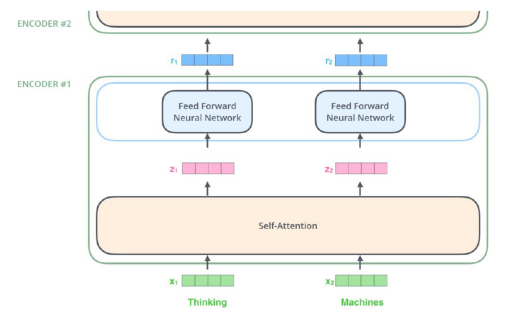

The diagram illustrates a two-layer encoder structure. At the bottom, there are two input tokens labeled 'x1' and 'x2' with the words 'Thinking' and 'Machines' respectively. These inputs are processed through a 'Self-Attention' layer. The outputs from this layer are labeled 'z1' and 'z2'. These are then fed into two separate 'Feed Forward Neural Network' blocks. The outputs from these networks are labeled 'r1' and 'r2'. The entire process is encapsulated within two encoder layers labeled 'ENCODER #1' and 'ENCODER #2'.

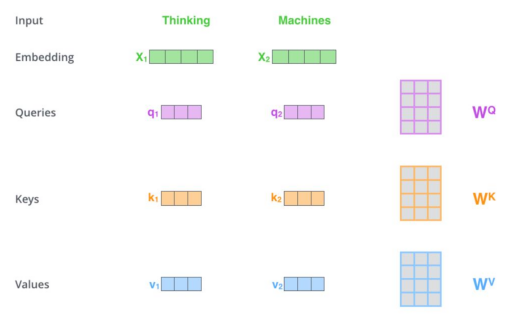

The diagram illustrates the process of transforming input words into embeddings, queries, keys, and values. It includes the following elements: 

- Input: 'Thinking' and 'Machines' in green.
- Embedding: 'X1' and 'X2' in green with corresponding boxes.
- Queries: 'q1' and 'q2' in purple with corresponding boxes, and a matrix labeled 'WQ'.
- Keys: 'k1' and 'k2' in orange with corresponding boxes, and a matrix labeled 'WK'.
- Values: 'v1' and 'v2' in blue with corresponding boxes, and a matrix labeled 'WV'.

In [ ]:
rag_system.display_results(results)

## Example 2: Understanding the Transformer Decoder

In [ ]:
query_text = "Explain the transformer decoder"
results = rag_system.query(query_text, top_k = 2)

A transformer decoder is a part of the transformer model used in sequence-to-sequence tasks like language translation. It receives the processed input from the encoder side, which is transformed into a set of attention vectors, K and V. These vectors are used in its "encoder-decoder attention" layer, which helps it focus on relevant parts of the input sequence. 

In the decoding phase, each step outputs an element from the output sequence (for instance, an English translation sentence). This process is repeated until a special symbol is reached, indicating the end of the output. The output of each step is inputted to the next time step's decoder, passing up the decoding results similarly to the encoders. The decoder inputs also undergo embedding and positional encoding to indicate each word's position.

The decoder structure aligns with the encoder's with identical layers (but they don't share weights). It's essentially a stack of multiple layers of identical decoders (number may vary).

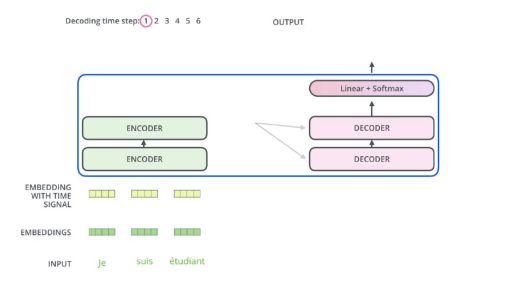

The diagram illustrates a sequence-to-sequence model with encoders and decoders. 

- At the top, it shows 'Decoding time step: 1 2 3 4 5 6 OUTPUT' with '1' circled.
- The main section is a box containing two 'ENCODER' blocks on the left, connected by an arrow, and two 'DECODER' blocks on the right, also connected by an arrow. An arrow points from the encoders to the decoders.
- Above the decoders, there is a 'Linear + Softmax' block with an upward arrow indicating output.
- Below the main section, there are 'EMBEDDING WITH TIME SIGNAL' and 'EMBEDDINGS' represented by small green and yellow blocks.
- At the bottom, the 'INPUT' is shown as 'Je suis étudiant'.

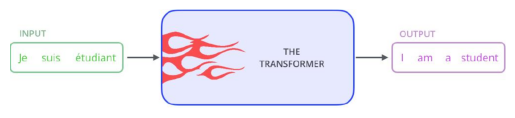

The diagram illustrates a transformation process. 

- On the left, there is a green box labeled 'INPUT' containing the French words 'Je suis étudiant'.
- An arrow points to a central box labeled 'THE TRANSFORMER' with a red flame-like design.
- Another arrow points from the central box to a purple box labeled 'OUTPUT' containing the English words 'I am a student'.

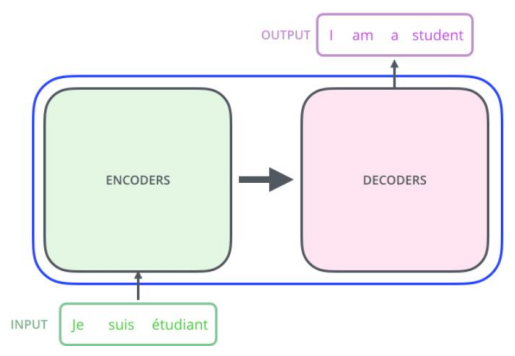

The diagram illustrates a translation process using encoders and decoders. On the left, there is a green box labeled 'ENCODERS' with an arrow pointing to a pink box labeled 'DECODERS' on the right. Below the encoders, there is an input text in green: 'INPUT Je suis étudiant'. Above the decoders, there is an output text in purple: 'OUTPUT I am a student'.

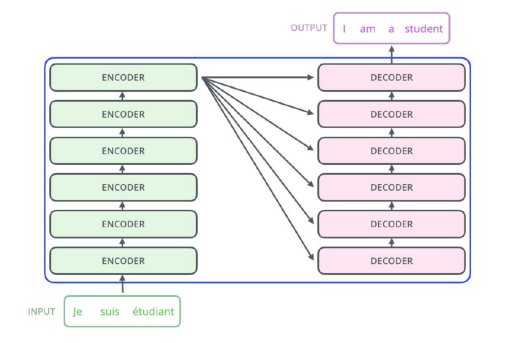

This is a diagram illustrating an encoder-decoder architecture. 

Text in the diagram:
- INPUT: Je suis étudiant
- OUTPUT: I am a student

The left side contains five boxes labeled 'ENCODER' stacked vertically, connected with arrows indicating a sequential process. The right side contains five boxes labeled 'DECODER' stacked vertically, also connected with arrows. Arrows from the encoders point to the decoders, indicating the flow of information from the encoder to the decoder.

In [ ]:
rag_system.display_results(results)

### Try this notebook out with your own files with images you'd like to see in RAG responses! You can get started with [Unstructured Platform](https://unstructured.io/developers) with a 14 day free trial!